**Author:** Mathurin Choblet (mchoblet@uliege.be)

**Date:** 25.11.2025


# Data

* Modis
* PACE
* GC-OLCI
* GC-MY
* GC-L4

* OC-CCI:
 /home/mathu/otc25_project/CCI_ALL-v6.0-DAILY.nc


* GC - ATL - OLCI - 300m
  cmems_obs-oc_atl_bgc-plankton_nrt_l3-olci-300m_P1D_multi-vars_28.00W-13.00E_35.00N-66.00N_2025-04-20-2025-06-04.nc

* GC - ATL - MY - L3 -
  cmems_obs-oc_atl_bgc-plankton_my_l3-multi-1km_P1D_multi-vars_27.99W-12.99E_35.01N-65.99N_2025-04-20-2025-06-04.nc
  
* GC - ATL - MY - L4 
  cmems_obs-oc_atl_bgc-plankton_my_l4-gapfree-multi-1km_P1D_multi-vars_27.99W-12.99E_35.01N-65.99N_2025-04-20-2025-06-04.nc

* GC - MED - MY - L3 cmems_obs-oc_med_bgc-plankton_my_l3-multi-1km_P1D_multi-vars_5.99W-17.99E_35.01N-45.99N_2025-04-20-2025-06-04.nc

* GC - MED - MY - L4  cmems_obs-oc_med_bgc-plankton_my_l4-gapfree-multi-1km_P1D_CHL_5.99W-17.99E_35.01N-45.99N_2025-04-20-2025-06-04.nc

In [1]:
import xarray as xr
import glob
import numpy as np
import os, re
import matplotlib.pyplot as plt
import datetime
import matplotlib.gridspec as GridSpec
from matplotlib.ticker import FuncFormatter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import seaborn as sns
import matplotlib.patches as patches
import pandas as pd
sns.set_context('talk')
land = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])

In [2]:
import warnings

# Suppress the specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Degrees of freedom <= 0 for slice')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in divide')

In [3]:
papaths=sorted(glob.glob('/home/mathu/otc25_project/data_cnv/*.cnv'))

papaths = [p for p in papaths if (('St07' not in p) and ('dark' not in p.lower()) and ('/home/mathu/phd_content/seabird_ctd/L05_St30_2_02062025.cnv' not in p)) ]

#variables=['Pressure','Temperature','Conductivity','Oxygen raw','pH','Fluorescence','Turbidity','PAR','Beam Transmission','Salinity','Oxygen','Density','Sound Velocity','Average Sound Velocity','flag']

datasets={}

for file_path in papaths:
    # Read file, including header and found the *END* position
    with open(file_path, 'r') as f:
        lines = f.readlines()
    for i, ln in enumerate(lines):
        if ln.strip().startswith('*END*'):
            skiprows = i + 1
            break
    else:
        raise RuntimeError("'*END*' nicht gefunden.")
    
    header = lines[:skiprows]
    
    # --- colum names + simple units '# name i = ...' ---
    nice_names, units = [], []
    name_re = re.compile(r"#\s*name\s+\d+\s*=\s*(.+)$")
    for ln in header:
        m = name_re.match(ln)
        if not m:
            continue
        rhs = m.group(1).strip()  # z.B. "prdM: Pressure, Strain Gauge [db]"
        # label before '['
        label = rhs.split('[', 1)[0]
        # "nicer" Name = part after ':' 
        nice = label.split(':', 1)[-1].strip()
        # if komma in name
        if ',' in nice:
            nice = nice.split(',', 1)[0].strip()
        if not nice:
            nice = label.strip()
        nice_names.append(nice)
    
        # units continent in [...] 
        u = ''
        if '[' in rhs and ']' in rhs:
            u = rhs.split('[', 1)[1].split(']', 1)[0].strip()
            if ',' in u:
                u = u.split(',')[-1].strip()
        units.append(u)
    
    # --- Metadata
    def pick_after_eq(key):
        for ln in header:
            if key in ln:
                if '=' in ln:
                    return ln.split('=', 1)[1].split('[')[0].strip()
                elif ':' in ln:
                    return ln.split(':', 1)[1].strip()
        return None
    
    time_str = (pick_after_eq('NMEA UTC (Time)') or
                pick_after_eq('System UTC') or
                pick_after_eq('# start_time'))
    dt = datetime.datetime.strptime(time_str, "%b %d %Y %H:%M:%S")
    
    # --- Lat/Lon: "DD MM.mm H" -> decimal degree
    def dm_to_deg(s):
        # e.g. "69 55.27 N"
        if not s:
            return np.nan
        parts = s.split()
        if len(parts) < 3:
            return np.nan
        deg = int(parts[0])
        minutes = float(parts[1].replace(',', '.'))  # if komma
        hemi = parts[2].upper()
        val = deg + minutes/60.0
        return -val if hemi in ('S','W') else val
    
    lat = dm_to_deg(pick_after_eq('NMEA Latitude'))
    lon = dm_to_deg(pick_after_eq('NMEA Longitude'))
    station = pick_after_eq('Station')

    # read in data
    data = np.loadtxt(file_path, skiprows=skiprows)

    if len(data)==0:
        continue
    
    if data.ndim == 1:
        data = data[None, :]
    
    # build dataset, first column as coordinate
    coord_name = nice_names[0].lower().replace(' ', '_')  # z.B. 'pressure'
    coords = {coord_name: (coord_name, data[:, 0])}
    
    data_vars = {
        n.lower().replace(' ', '_'): (coord_name, data[:, j], {'units': units[j]})
        for j, n in enumerate(nice_names[1:], start=1)  #start at index 1 to exclude the coordinate
    }
    
    ds = xr.Dataset(data_vars=data_vars, coords=coords)
    
    # add coordinates and attributes
    ds = ds.assign_coords(time=np.datetime64(dt),lon=lon,lat=lat,station=station)
    ds.attrs.update({'source_file': os.path.basename(file_path)})

    if station in datasets.keys():
        #if type(datasets[station])==xr.core.dataset.Dataset:
        #    datasets[station]=[datasets[station]]
        #    datasets[station].append(ds)
        if type(datasets[station])==list:
            datasets[station].append(ds)
    else:
        datasets[station]=[ds]

from collections import defaultdict
merged = defaultdict(list)
for k, v in datasets.items():
    merged[k.split('_')[0].split('-')[0].zfill(2)].extend(v)

/tmp/ipykernel_112906/4291916751.py:103: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=np.datetime64(dt),lon=lon,lat=lat,station=station)
/tmp/ipykernel_112906/4291916751.py:103: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

In [4]:
df1=pd.read_csv('/home/mathu/prod/Leg03/OneOcean_InLine_ACS_20250423_20250505_Products_full_Leg03_v20250530.csv')[['dt','lat','lon','Chl_lineheight']]
df2=pd.read_csv('/home/mathu/prod/Leg04/OneOcean_InLine_ACS_20250508_20250602_Products_Leg04_v20250603.csv')[['dt','lat','lon','Chl_lineheight']]

times=np.concatenate([df1['dt'].values,df2['dt'].values])
vals=np.concatenate([df1['Chl_lineheight'],df2['Chl_lineheight']])
lats=np.concatenate([df1['lat'],df2['lat']])
lons=np.concatenate([df1['lon'],df2['lon']])
inline=xr.Dataset(data_vars={'CHL':('time',vals),'lat':('time',lats),'lon':('time',lons)},coords={'time':times})

times=[np.datetime64(t) for t in times]
inline['time']=times

/tmp/ipykernel_112906/2847703003.py:11: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  inline['time']=times
/tmp/ipykernel_112906/2847703003.py:11: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahea

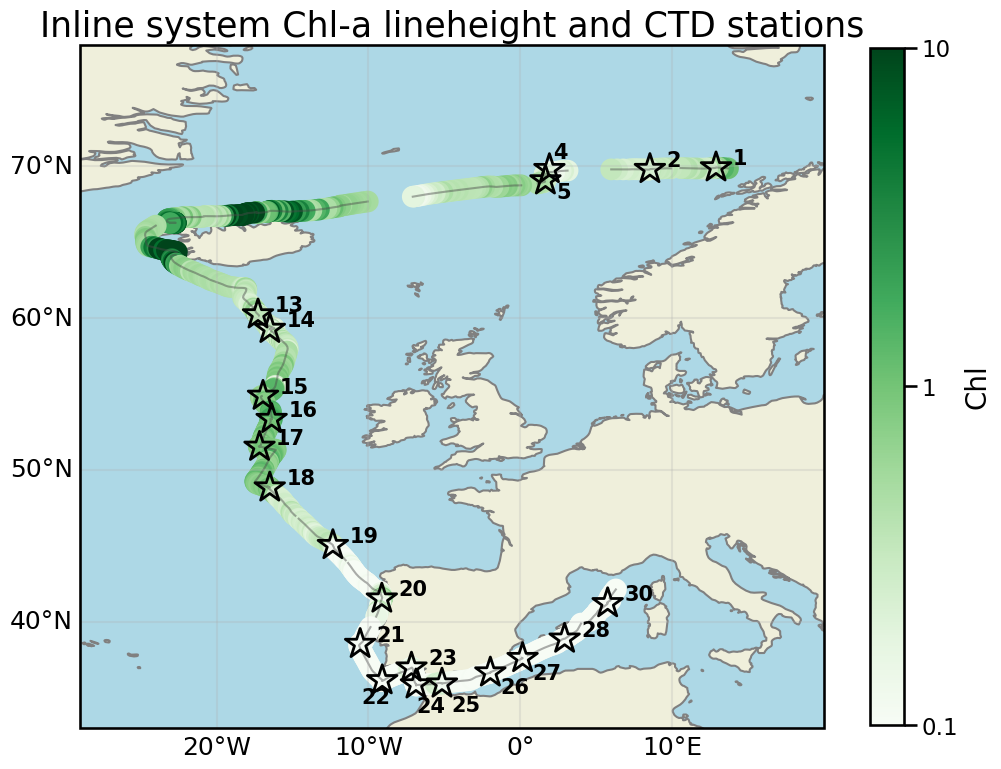

In [21]:
extent=[-29,20,33,78]

time=["2025-04-20","2025-06-08"]
#time=["2025-04-20","2025-05-05"]
#time=["2025-05-05","2025-05-20"]
#time=["2025-05-20","2025-06-03"]


data=inline.sel(time=slice(time[0],time[1])).resample(time='h').mean()
step=1
vmin=-1
vmax=1
size=200
cmap='Greens'
#markercolor='white'
#markercolor='lightgray'
markercolor='black'
lw=2

offsets={
'04':[3,10],
'05':[8,-15],
'22':[-15,-17],
'24':[0,-20],
'25':[7,-20],
'26':[7,-15],
'27':[7,-15],
}

fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(land,zorder=0)
#ax.set_facecolor("#e8f6ff")  # light blue ocean
ax.set_facecolor("lightblue")  # light blue ocean

plot=ax.scatter(data['lon'][::step],data['lat'][::step],transform=ccrs.PlateCarree(),c=np.log10(data['CHL'][::step]),cmap=cmap,vmin=vmin,vmax=vmax,s=size)

gl=ax.gridlines(draw_labels=["bottom", "left"], alpha=0.25)

ax.plot(data['lon'], data['lat'], transform=ccrs.PlateCarree(),
        lw=1.5, color="#4a4a4a", alpha=0.45, zorder=1)
cbar = plt.colorbar(plot, shrink=0.88)

cbar.set_ticks([vmin,0,vmax])

#cbar.set_label('Log10 Chl')
cbar.set_label('Chl',fontsize=20)
cbar.ax.set_yticklabels([0.1,1,10])
plt.title('Inline system Chl-a lineheight and CTD stations',fontsize=25)

#################### plot CTD markers and annotations ####################
for i,(k,v) in enumerate(merged.items()):
    data2=v[0]
    
    if (data2['time'].values>=np.datetime64(time[0])) and (data2['time'].values<np.datetime64(time[1])):
        #select first cast (doesn't matter which one we take)

        
        if k=='04':
            lo=data2['lon'];la=data2['lat']+0.2     
        elif k=='05':
            lo=data2['lon'];la=data2['lat']-0.2
        else:
            lo=data2['lon'];la=data2['lat']
    
        ax.scatter(lo,la,transform=ccrs.PlateCarree(),marker='*',s=500,color=markercolor,facecolor='none',zorder=100,linewidth=lw)
    
        if k in offsets.keys():
            x,y=offsets[k]
        else:
            x=12;y=2
        #a bit of position manipulation for separating stars betters
    
        ax.annotate(int(k), 
                   xy=(data2['lon'],data2['lat']), 
                   xytext=(x, y),  # Offset from the point
                   textcoords='offset points',
                   fontsize=15,
                   fontweight='bold',
                   color='black')

fig.savefig('map_simple.png',dpi=300,bbox_inches='tight')

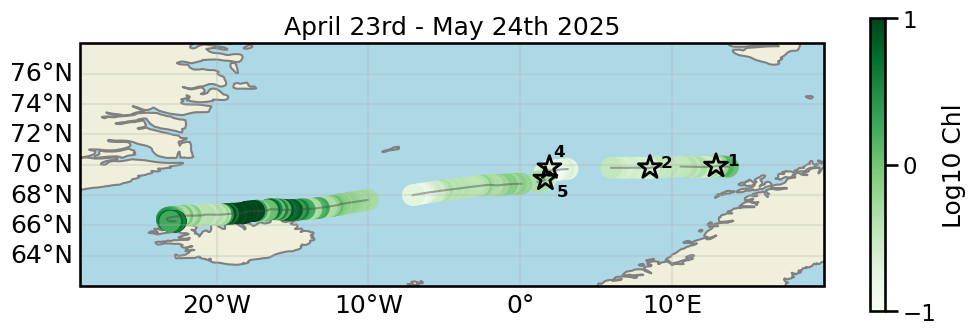

In [49]:
extent=[-29,20,62,78]
figsize=(12, 4)

time=["2025-04-23","2025-05-03"]
#time=["2025-05-05","2025-05-20"]
#time=["2025-05-20","2025-06-03"]


data=inline.sel(time=slice(time[0],time[1])).resample(time='h').mean()
step=1
vmin=-1
vmax=1
size=200
cmap='Greens'
#markercolor='white'
#markercolor='lightgray'
markercolor='black'
lw=2

offsets={
'04':[3,10],
'05':[8,-15],
'22':[-15,-15],
'24':[0,-15],
'25':[7,-13],
'26':[7,-13],
'27':[7,-13],
}

fig = plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(land,zorder=0)
#ax.set_facecolor("#e8f6ff")  # light blue ocean
ax.set_facecolor("lightblue")  # light blue ocean
gl=ax.gridlines(draw_labels=["bottom", "left"], alpha=0.25)

plot=ax.scatter(data['lon'][::step],data['lat'][::step],transform=ccrs.PlateCarree(),c=np.log10(data['CHL'][::step]),cmap=cmap,vmin=vmin,vmax=vmax,s=size)

ax.plot(data['lon'], data['lat'], transform=ccrs.PlateCarree(),
        lw=1.5, color="#4a4a4a", alpha=0.45, zorder=1)

cbar = plt.colorbar(plot, shrink=0.95)

cbar.set_ticks([vmin,0,vmax])

cbar.set_label('Log10 Chl')
#plt.title('Inline system Chlorophyll lineheight')
plt.title('April 23rd - May 24th 2025')


#################### plot CTD markers and annotations ####################
for i,(k,v) in enumerate(merged.items()):
    #select first cast (doesn't matter which one we take)
    data2=v[0]
    if (data2['time'].values>=np.datetime64(time[0])) and (data2['time'].values<np.datetime64(time[1])):
        if k=='04':
            lo=data2['lon'];la=data2['lat']+0.2     
        elif k=='05':
            lo=data2['lon'];la=data2['lat']-0.2
        else:
            lo=data2['lon'];la=data2['lat']
    
        ax.scatter(lo,la,transform=ccrs.PlateCarree(),marker='*',s=300,color=markercolor,facecolor='none',zorder=100,linewidth=lw)
    
        if k in offsets.keys():
            x,y=offsets[k]
        else:
            x=8;y=0
        #a bit of position manipulation for separating stars betters
    
        ax.annotate(int(k), 
                   xy=(data2['lon'],data2['lat']), 
                   xytext=(x, y),  # Offset from the point
                   textcoords='offset points',
                   fontsize=12,
                   fontweight='bold',
                   color='black')

In [5]:
modis=sorted(glob.glob('/home/mathu/otc25_project/AQUA_MODIS/*DAY*4km.nc'))
PACE=sorted(glob.glob('/home/mathu/otc25_project/PACE/*DAY*4km*.nc'))

def preprocess(ds):
    path=ds.encoding['source']
    #ds=ds.expand_dims('time')
    date=os.path.basename(path).split('.')[1]
    time= pd.to_datetime(f"{date[:4]}-{date[4:6]}-{date[6:8]}")
    ds=ds.assign_coords(time=[time])
    ds=ds.sortby('lat')
    ds=ds.sel(lat=slice(18,71),lon=slice(-28,35))
    return ds

pace=xr.open_mfdataset(PACE,preprocess=preprocess).load()
modis=xr.open_mfdataset(modis,preprocess=preprocess).load()

In [6]:
l3_olci=xr.open_dataset('/home/mathu/otc25_project/DATA/copernicus-data/chl_l3_OLCI_300m_OTC25.nc')
print(l3_olci.nbytes/(1024**3))
l3_chl=xr.open_dataset('/home/mathu/otc25_project/DATA/copernicus-data/chl_l3_OTC25.nc')
print(l3_chl.nbytes/(1024**3))

9.19445325434208
0.16346363723278046


In [7]:
l4=xr.open_dataset('/home/mathu/otc25_project/DATA/copernicus-data/chl_gapfree_OTC25.nc')
l4.nbytes/(1024**3)

0.16346363723278046

In [8]:
oc_cci=xr.open_dataset('/home/mathu/otc25_project/CCI_ALL-v6.0-DAILY.nc')

gc_atl_olci_l3=xr.open_dataset('copernicus-data/cmems_obs-oc_atl_bgc-plankton_nrt_l3-olci-300m_P1D_multi-vars_28.00W-13.00E_35.00N-66.00N_2025-04-20-2025-06-04.nc')
gc_atl_l3=xr.open_dataset('copernicus-data/cmems_obs-oc_atl_bgc-plankton_my_l3-multi-1km_P1D_multi-vars_27.99W-12.99E_35.01N-65.99N_2025-04-20-2025-06-04.nc')
gc_atl_l4=xr.open_dataset('copernicus-data/cmems_obs-oc_atl_bgc-plankton_my_l4-gapfree-multi-1km_P1D_multi-vars_27.99W-12.99E_35.01N-65.99N_2025-04-20-2025-06-04.nc')

gc_med_l3=xr.open_dataset('copernicus-data/cmems_obs-oc_med_bgc-plankton_my_l3-multi-1km_P1D_multi-vars_5.99W-17.99E_35.01N-45.99N_2025-04-20-2025-06-04.nc')
gc_med_l4=xr.open_dataset('copernicus-data/cmems_obs-oc_med_bgc-plankton_my_l4-gapfree-multi-1km_P1D_CHL_5.99W-17.99E_35.01N-45.99N_2025-04-20-2025-06-04.nc')

In [9]:
def match_satellite(ds=pace,
    lat_var='lat',
    lon_var='lon',
    chlor_val='chlor_a'):

    def bw_filter(x):
        mean=np.nanmean(x)
        std=np.nanstd(x)
    
        mask=(x>(x-1.5*std)) & (x<(x+1.5*std)) & (~np.isnan(x))
        x_masked=x[mask]
    
        mean_filt=np.mean(x_masked)
        std_filt=np.std(x_masked)
    
        #coefficient of variation
        cv=std_filt/mean_filt
        
        return mean_filt,std_filt,cv
    
    #inline system replace latitudes and longitudes
    inline_p=inline.copy(deep=True)
    
    lat_grid=ds[lat_var].values
    lon_grid=ds[lon_var].values
    in_lat=inline.lat.values
    in_lon=inline.lon.values
    
    #select nearest longitude
    lons=lon_grid[np.argmin(np.abs((in_lon[:,None]-lon_grid)),axis=1)]
    lats=lat_grid[np.argmin(np.abs((in_lat[:,None]-lat_grid)),axis=1)]
    
    #inline system replace latitudes and longitudes
    inline_p=inline.copy(deep=True)
    inline_p['lat'].data=lats
    inline_p['lon'].data=lons
    inline_p=inline_p.assign_coords({'lat':inline_p['lat'],'lon':inline_p['lon']})
    inline_p['time']=pd.to_datetime(inline_p['time'].values)
    
    unique_pos=np.unique(list(zip(lats,lons)),axis=0)
    
    times=[]
    vals=[]
    num=[]
    
    for p in unique_pos:
        mask=(inline_p.lat==p[0]) & (inline_p.lon==p[1]) 
        select=inline_p.isel(time=mask)
        mask2=~np.isnan(select['CHL'])
        select2=select.isel(time=mask2)
        num.append(np.count_nonzero(mask2))
        times.append(select['time'].mean().values)
        vals.append(select['CHL'].mean('time').values.item())
    
    #binned
    inline_b=xr.DataArray(vals,coords={'time':times,'lat':('time',unique_pos[:,0]),'lon':('time',unique_pos[:,1])},dims='time')
    
    #APPROACH: COMPUTE EVERYTHING AND SELECT LATER (e.g. with filt)
    sat_vals=[]
    sat_vals_mean=[]
    sat_vals_med=[]
    sat_vals_std=[]
    filt_m=[]
    filt_std=[]
    filt_cv=[]
    counts=[]
    
    time2=[]
    for i,p in enumerate(unique_pos):
        time=ds.time.sel(time=times[i],method='nearest').values
        time2.append(time)
        lat_i=np.argwhere(ds[lat_var].values==p[0]).item()
        lon_i=np.argwhere(ds[lon_var].values==p[1]).item()
    
        sat_vals.append(ds[chlor_val].isel({lat_var:lat_i,lon_var:lon_i}).sel({'time':time}).values.item())
        
        selec=ds[chlor_val].isel({lat_var:slice(lat_i-1,lat_i+2),lon_var:slice(lon_i-1,lon_i+2)}).sel({'time':time})
    
        count=np.count_nonzero(~np.isnan(selec))
        counts.append(count)
        
        if count>5:
            sat_vals_mean.append(selec.mean().values.item())
            sat_vals_med.append(selec.median().values.item())
            sat_vals_std.append(selec.std().values.item())
            m,s,cv=bw_filter(selec.values.reshape(-1))
            filt_m.append(m)
            filt_std.append(s)
            filt_cv.append(cv)
        else:
            sat_vals_mean.append(np.nan)
            sat_vals_med.append(np.nan)
            sat_vals_std.append(np.nan)
            m,s,cv=bw_filter(selec.values.reshape(-1))
            filt_m.append(np.nan)
            filt_std.append(np.nan)
            filt_cv.append(np.nan)
    
    dicti={
        'sat_vals':np.array(sat_vals),
        'sat_vals_mean':np.array(sat_vals_mean),
        'sat_vals_med':np.array(sat_vals_med),
        'sat_vals_std':np.array(sat_vals_std),
        'filt_m':np.array(filt_m),
        'filt_std':np.array(filt_std),
        'filt_cv':np.array(filt_cv),
        'counts':np.array(counts),
    
    }
    time=np.array(time2)
    
    dicti_ds={}
    for k,v in dicti.items():
        ds=xr.DataArray(v,coords={'time':time,'lat':('time',unique_pos[:,0]),'lon':('time',unique_pos[:,1])},dims='time')
        dicti_ds[k]=ds
    
    dataset=xr.Dataset(dicti_ds)    

    return dataset,inline_b

In [10]:
%%time
ds_pace,inline_b_pace=match_satellite(pace)
ds_modisa,inline_b_modisa=match_satellite(modis)
ds_l3,inline_b_l3=match_satellite(l3_chl,lat_var='latitude',lon_var='longitude',chlor_val='CHL')
ds_l3olci,inline_b_olci=match_satellite(l3_olci,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

CPU times: user 1min 33s, sys: 1.52 s, total: 1min 35s
Wall time: 1min 36s


In [11]:
gc_atl_olci_l3=xr.open_dataset('copernicus-data/cmems_obs-oc_atl_bgc-plankton_nrt_l3-olci-300m_P1D_multi-vars_28.00W-13.00E_35.00N-66.00N_2025-04-20-2025-06-04.nc')
gc_atl_l3=xr.open_dataset('copernicus-data/cmems_obs-oc_atl_bgc-plankton_my_l3-multi-1km_P1D_multi-vars_27.99W-12.99E_35.01N-65.99N_2025-04-20-2025-06-04.nc')
gc_atl_l4=xr.open_dataset('copernicus-data/cmems_obs-oc_atl_bgc-plankton_my_l4-gapfree-multi-1km_P1D_multi-vars_27.99W-12.99E_35.01N-65.99N_2025-04-20-2025-06-04.nc')

gc_med_l3=xr.open_dataset('copernicus-data/cmems_obs-oc_med_bgc-plankton_my_l3-multi-1km_P1D_multi-vars_5.99W-17.99E_35.01N-45.99N_2025-04-20-2025-06-04.nc')
gc_med_l4=xr.open_dataset('copernicus-data/cmems_obs-oc_med_bgc-plankton_my_l4-gapfree-multi-1km_P1D_CHL_5.99W-17.99E_35.01N-45.99N_2025-04-20-2025-06-04.nc')

In [12]:
ds_l4,inline_l4=match_satellite(l4,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

In [13]:
ds_oc_cci,inline_oc_cci=match_satellite(oc_cci)

In [14]:
%%time
#the oldi matchup tages longes...
ds_gc_atl_olci,inline_gc_atl_olci=match_satellite(gc_atl_olci_l3,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

CPU times: user 1min, sys: 980 ms, total: 1min
Wall time: 1min 1s


In [15]:
%%time
ds_gc_atl_l3,inline_gc_atl_l3=match_satellite(gc_atl_l3,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

CPU times: user 36.7 s, sys: 488 ms, total: 37.2 s
Wall time: 37.3 s


In [16]:
%%time
ds_gc_atl_l4,inline_gc_atl_l4=match_satellite(gc_atl_l4,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

CPU times: user 37.1 s, sys: 531 ms, total: 37.7 s
Wall time: 37.8 s


In [17]:
%%time
ds_gc_med_l3,inline_gc_med_l3=match_satellite(gc_med_l3,lat_var='latitude',lon_var='longitude',chlor_val='CHL')
ds_gc_med_l4,inline_gc_med_l4=match_satellite(gc_med_l4,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

CPU times: user 29.1 s, sys: 432 ms, total: 29.5 s
Wall time: 29.6 s


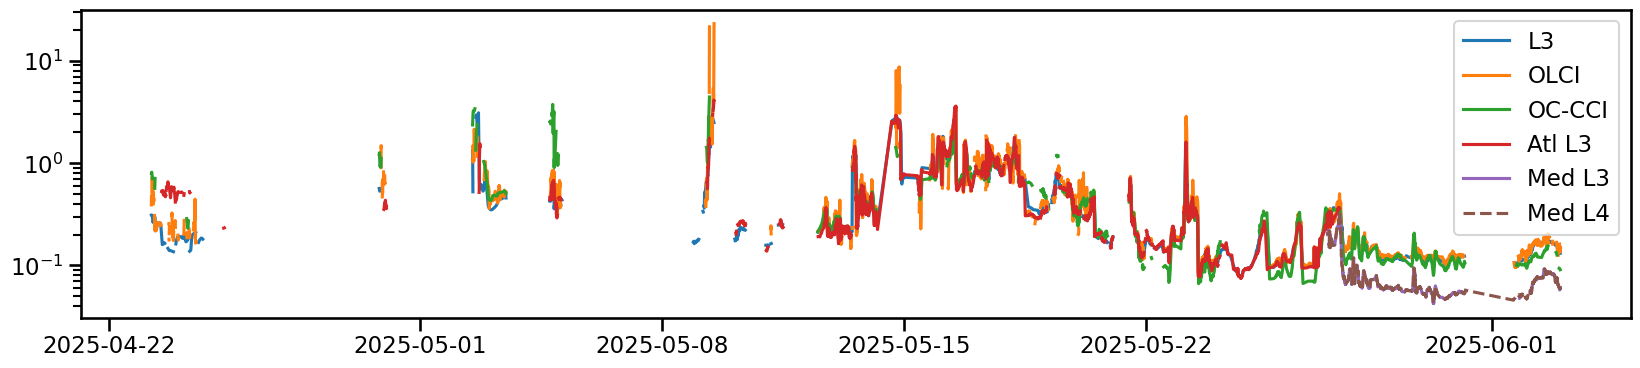

In [18]:
plt.figure(figsize=(20,4))
plt.plot(inline_b_l3['time'].sortby('time').values,ds_l3['filt_m'].sortby('time'),label='L3')
plt.plot(inline_b_olci['time'].sortby('time').values,ds_l3olci['filt_m'].sortby('time'),label='OLCI')
plt.plot(inline_oc_cci['time'].sortby('time').values,ds_oc_cci['filt_m'].sortby('time'),label='OC-CCI')
plt.plot(inline_gc_atl_l3['time'].sortby('time').values,ds_gc_atl_l3['filt_m'].sortby('time'),label='Atl L3')
plt.plot(inline_gc_med_l3['time'].sortby('time').values,ds_gc_med_l3['filt_m'].sortby('time'),label='Med L3')
plt.plot(inline_gc_med_l4['time'].sortby('time').values,ds_gc_med_l4['filt_m'].sortby('time'),label='Med L4',ls='--')
plt.yscale('log')
plt.legend()

In [19]:
inline_b=inline_b_pace

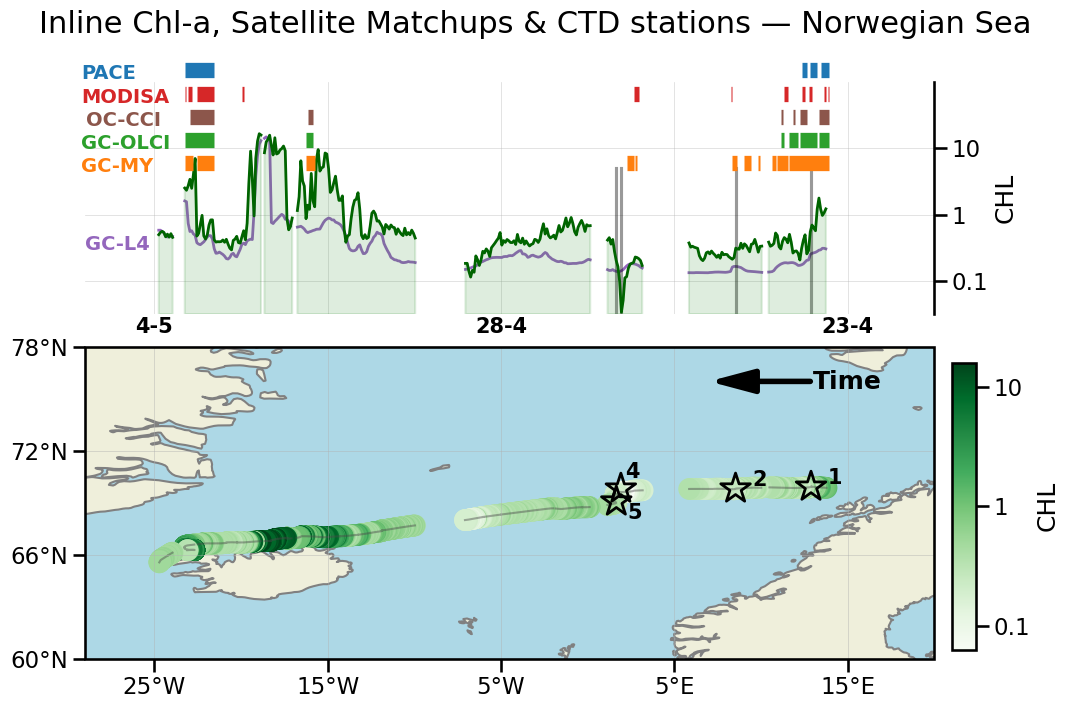

In [94]:
# --- imports ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# ---------------- user context ----------------
offsets={'04':[3,10],'05':[8,-15],'22':[-15,-15],'24':[0,-15],
         '25':[7,-13],'26':[7,-13],'27':[7,-13]}
extent=[-29,20,60,78]
figsize=(12, 9)

vmin=-1.2
vmax=1.2

time=["2025-04-23","2025-05-04 06:00:00"]
res='10min'

# ---------- data subset + hourly mean (INLINE) ----------
ds = inline.sel(time=slice(time[0], time[1])).resample(time=res).mean()
ds = ds.assign(logchl=np.log10(ds.CHL))

# ---------- longitudinal binning ----------
bin_size = 0.1
lon_edges = np.arange(extent[0], extent[1] + bin_size, bin_size)
gb = ds.groupby_bins('lon', lon_edges)
binned = gb.mean()
lon_centers_line = np.array([iv.mid for iv in binned.lon_bins.values])
logchl_mean = binned['logchl'].values
lon_centers_bins = (lon_edges[:-1] + lon_edges[1:]) / 2


# ---------------- figure layout ----------------
fig = plt.figure(figsize=figsize)
gs  = GridSpec(2, 2, height_ratios=[1, 2.5], width_ratios=[30, 1], hspace=-0.25, wspace=0.12)

xticks = np.arange(np.ceil(extent[0]/5)*5, extent[1]+1, 10)

# ===== MAP (bottom) =====
ax_map = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree())
ax_map.set_extent(extent, crs=ccrs.PlateCarree())
ax_map.add_feature(land, zorder=0)
ax_map.set_facecolor("lightblue")

# keep longitude ticks visible here
ax_map.set_xticks(xticks, crs=ccrs.PlateCarree())
ax_map.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

yticks = np.arange(np.ceil(extent[2]/2)*2, extent[3]+1, 6)
ax_map.set_yticks(yticks, crs=ccrs.PlateCarree())
ax_map.yaxis.set_major_formatter(LatitudeFormatter())
ax_map.grid(True, alpha=0.5, lw=0.6)

plot = ax_map.scatter(ds['lon'], ds['lat'], transform=ccrs.PlateCarree(),
                      c=ds['logchl'], cmap=cmap, vmin=vmin, vmax=vmax, s=200)
ax_map.plot(ds['lon'], ds['lat'], transform=ccrs.PlateCarree(),
            lw=1.5, color="#4a4a4a", alpha=0.45, zorder=1)

# colorbar
fig.subplots_adjust(top=0.90)   # tweak if your suptitle needs more space
# --- colorbar (recompute positions *after* adjusting layout) ---
pos = ax_map.get_position()

cax = fig.add_subplot(gs[1,1])

cax.set_position([pos.x1+0.015, pos.y0 + 0.01, 0.02, pos.height*0.92])
cbar = plt.colorbar(plot, cax=cax, shrink=0.5)



cbar.set_ticks([-1, 0, 1])
cbar.ax.set_yticklabels([0.1,1,10])
cbar.set_label('CHL')

# ===== TOP PANEL =====
ax_top = fig.add_subplot(gs[0,0], sharex=ax_map)
ax_top.set_ylim(-1.5, 2)

# main green line
ax_top.plot(lon_centers_line, logchl_mean, lw=2, color='darkgreen', zorder=10)
ax_top.fill_between(lon_centers_line, -1.5, logchl_mean, alpha=0.15,
                    color='forestgreen', zorder=5)

#adding a GC-L4 line on top filt_m
ax_top.plot(lon_centers_line, np.where(np.isnan(logchl_mean),np.nan,np.log10(ds_l4['filt_m'].assign_coords({'time':inline_l4['time'].values}).sortby('time').sel(time=slice(time[0], time[1])).groupby_bins('lon',lon_edges).mean())) ,color='tab:purple',lw=2)
ax_top.text(0,0.3, 'GC-L4', va='center', ha='left', fontsize=14, fontweight='bold', color='tab:purple', transform=ax_top.transAxes, clip_on=False)

# right-side y-axis (fewer ticks)
ax_top.yaxis.set_label_position("right")
ax_top.yaxis.tick_right()
ax_top.set_ylabel('CHL')
ax_top.set_yticks([-1, 0, 1])
ax_top.set_yticklabels([0.1, 1, 10])
ax_top.grid(alpha=0.5, lw=0.5, linestyle='-')

# remove unwanted spines and x-ticks on the *primary* top axis
ax_top.spines['top'].set_visible(False)
ax_top.spines['left'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(axis='x', which='both', length=0, labelbottom=False)

# ---- PACE availability line ----
ymin, ymax = ax_top.get_ylim()
y_avail = ymin + 0.9 * (ymax - ymin)

# ------- multiple availability overlays (stacked) -------
# name -> DataArray mapping (each must have coords 'time','lon'; NaN = missing)
datasets = {
    "PACE": xr.where(ds_pace['filt_cv']>0.15,np.nan,ds_pace['filt_m']),                # already drawn above; keep or remove here
    "MODISA": xr.where(ds_modisa['filt_cv']>0.15,np.nan,ds_modisa['filt_m']), 
    "GC-OLCI": xr.where(ds_l3olci['filt_cv']>0.15,np.nan,ds_l3olci['filt_m']),
    "GC-MY": xr.where(ds_l3['filt_cv']>0.15,np.nan,ds_l3['filt_m']),         
    "OC-CCI": xr.where(ds_oc_cci['filt_cv']>0.15,np.nan,ds_oc_cci['filt_m']),         #for test purposes, is this line very similar to OLCI?
}

from matplotlib.transforms import blended_transform_factory

# --- right after you create ax_top ---
# Give the figure a tiny bit of headroom so the bars/labels won’t be cut off


# This transform uses data for X and axes-fraction for Y
trans = blended_transform_factory(ax_top.transData, ax_top.transAxes)

# y-levels ABOVE the panel (in axes fraction). 1.0 = top edge of ax_top
levels_ax = {
    "PACE":   1.05,
    "MODISA": 0.95,
    "GC-OLCI":0.75,
    "GC-MY":  0.65,  
    "OC-CCI":  0.85,  
    #"GC-MY":  0.75,  
}
colors = {
    "PACE": "#1f77b4",   # blue
    "MODISA": "#d62728", # red
    "GC-MY": "#ff7f0e",   # orange
    "GC-OLCI": "#2ca02c",# green
    'OC-CCI': 'tab:brown',
}


lw = 11  # thickness of the availability bars

for name, darr in datasets.items():
    sat_i = darr.sortby('time').sel(time=slice(time[0], time[1]))
    has_i = sat_i.groupby_bins('lon', lon_edges).count().values > 0
    y_i   = levels_ax[name]  # axes-fraction, not data

    seg_start = None
    for lon, ok in zip(lon_centers_bins, has_i):
        if ok and seg_start is None:
            seg_start = lon
        elif not ok and seg_start is not None:
            ax_top.plot([seg_start, lon], [y_i, y_i],
                        color=colors[name], lw=lw, solid_capstyle='butt',
                        transform=trans, clip_on=False, zorder=30)
            seg_start = None
    if seg_start is not None:
        ax_top.plot([seg_start, lon_centers_bins[-1]], [y_i, y_i],
                    color=colors[name], lw=lw, solid_capstyle='butt',
                    transform=trans, clip_on=False, zorder=30)

    # label near the right edge (also in axes-fraction coords)
    try:
        xlab = lon_centers_bins[has_i][0] -6 # + 0.5
        ax_top.text(xlab, y_i-0.015, name, va='center', ha='left',
                    fontsize=14, fontweight='bold', color=colors[name],
                    transform=trans, clip_on=False)
    except IndexError:
        pass

# ---- DATES on a twin x-axis for the TOP panel only (clean + visible) ----
ax_date = ax_top.twiny()
ax_date.set_xlim(ax_top.get_xlim())

# put the ticks at the *bottom* of the top panel, but nudged upward into it
ax_date.xaxis.set_ticks_position('bottom')
for s in ax_date.spines.values():
    s.set_visible(False)                      # no spines at all
ax_date.tick_params(axis='x', top=False, bottom=True, length=0, pad=2)  # pad small => higher

# choose longitudes to annotate with their nearest dates
lon_marks = [15, -5, -25]
date_labels = []
for lon_val in lon_marks:
    idx = np.nanargmin(np.abs(ds['lon'] - lon_val).values)
    ti = ds.time[idx]
    date_labels.append(f"{ti.dt.day.values.item()}-{ti.dt.month.values.item()}")

ax_date.set_xticks(lon_marks)
# make dates pop (bold, slightly larger, with subtle white halo)
ax_date.set_xticklabels(
    date_labels,
    fontsize=15, fontweight='bold', color='black',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1.5)
)

# keep only the right y-axis; drop the rest
ax_top.spines['top'].set_visible(False)
ax_top.spines['left'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(axis='x', which='both', length=0, labelbottom=False)


# ===== CTD markers =====
for i,(k,v) in enumerate(merged.items()):
    data2 = v[0]
    if (data2['time'].values >= np.datetime64(time[0])) and (data2['time'].values < np.datetime64(time[1])):
        if k == '04':
            lo = data2['lon']; la = data2['lat'] + 0.2
        elif k == '05':
            lo = data2['lon']; la = data2['lat'] - 0.2
        else:
            lo = data2['lon']; la = data2['lat']
        ax_map.scatter(lo, la, transform=ccrs.PlateCarree(), marker='*', s=500,
                       color=markercolor, facecolor='none', zorder=100, linewidth=2)
        x_off, y_off = offsets.get(k, (12, 2))
        ax_map.annotate(int(k), xy=(data2['lon'], data2['lat']),
                        xytext=(x_off, y_off), textcoords='offset points',
                        fontsize=15, fontweight='bold', color='black')
        ax_top.plot([data2['lon'].values.item(), data2['lon'].values.item()],
                    [-1.5, 0.7], color='black', alpha=0.4)

# ===== Time arrow on map =====
ax_map.annotate(
    "Time",
    xy=(7, 76), xytext=(15, 76),
    xycoords=ccrs.PlateCarree()._as_mpl_transform(ax_map),
    textcoords=ccrs.PlateCarree()._as_mpl_transform(ax_map),
    ha='center', va='center',
    fontsize=18, fontweight='bold', color='black',
    arrowprops=dict(arrowstyle='-|>,head_width=0.4,head_length=1.5',
                    linewidth=4, color='black', shrinkA=0, shrinkB=0)
)

plt.suptitle("Inline Chl-a, Satellite Matchups & CTD stations — Norwegian Sea",fontsize=22)
fig.savefig('map_norwegian.png',format='png',dpi=600,bbox_inches='tight')
plt.show()

# Wider map versions that fit poster column

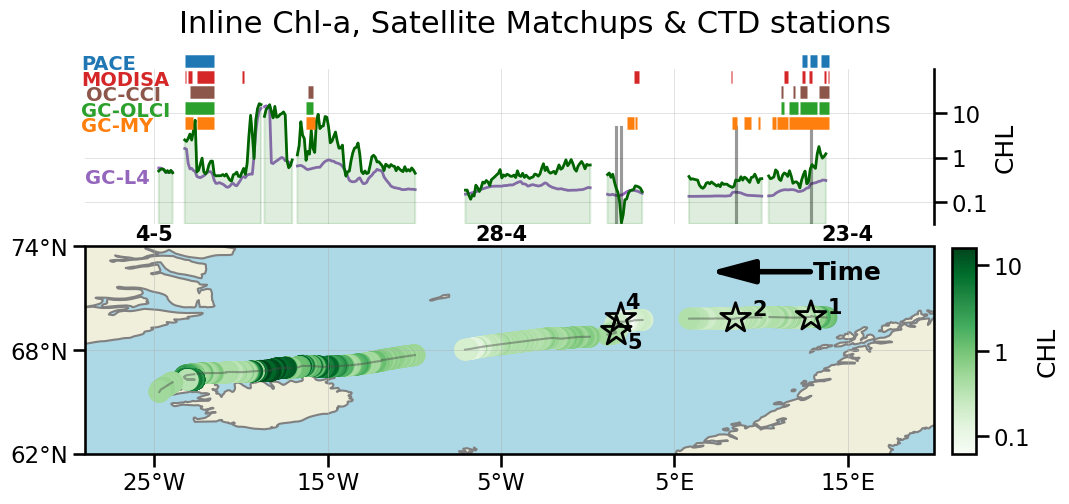

In [86]:
# --- imports ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# ---------------- user context ----------------
offsets={'04':[3,10],'05':[8,-15],'22':[-15,-15],'24':[0,-15],
         '25':[7,-13],'26':[7,-13],'27':[7,-13]}
#extent=[-29,20,60,78]
extent=[-29,20,62,74]
figsize=(12, 12/40*20)

vmin=-1.2
vmax=1.2

time=["2025-04-23","2025-05-04 06:00:00"]
res='10min'

# ---------- data subset + hourly mean (INLINE) ----------
ds = inline.sel(time=slice(time[0], time[1])).resample(time=res).mean()
ds = ds.assign(logchl=np.log10(ds.CHL))

# ---------- longitudinal binning ----------
bin_size = 0.1
lon_edges = np.arange(extent[0], extent[1] + bin_size, bin_size)
gb = ds.groupby_bins('lon', lon_edges)
binned = gb.mean()
lon_centers_line = np.array([iv.mid for iv in binned.lon_bins.values])
logchl_mean = binned['logchl'].values
lon_centers_bins = (lon_edges[:-1] + lon_edges[1:]) / 2


# ---------------- figure layout ----------------
fig = plt.figure(figsize=figsize)
gs  = GridSpec(2, 2, height_ratios=[1, 2.5], width_ratios=[30, 1], hspace=-0.25, wspace=0.12)

xticks = np.arange(np.ceil(extent[0]/5)*5, extent[1]+1, 10)

# ===== MAP (bottom) =====
ax_map = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree())
ax_map.set_extent(extent, crs=ccrs.PlateCarree())
ax_map.add_feature(land, zorder=0)
ax_map.set_facecolor("lightblue")

# keep longitude ticks visible here
ax_map.set_xticks(xticks, crs=ccrs.PlateCarree())
ax_map.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

yticks = np.arange(np.ceil(extent[2]/2)*2, extent[3]+1, 6)
ax_map.set_yticks(yticks, crs=ccrs.PlateCarree())
ax_map.yaxis.set_major_formatter(LatitudeFormatter())
ax_map.grid(True, alpha=0.5, lw=0.6)

plot = ax_map.scatter(ds['lon'], ds['lat'], transform=ccrs.PlateCarree(),
                      c=ds['logchl'], cmap=cmap, vmin=vmin, vmax=vmax, s=200)
ax_map.plot(ds['lon'], ds['lat'], transform=ccrs.PlateCarree(),
            lw=1.5, color="#4a4a4a", alpha=0.45, zorder=1)

# colorbar
fig.subplots_adjust(top=0.90)   # tweak if your suptitle needs more space
# --- colorbar (recompute positions *after* adjusting layout) ---
pos = ax_map.get_position()

cax = fig.add_subplot(gs[1,1])

#cax.set_position([pos.x1+0.015, pos.y0 + 0.01, 0.02, pos.height*0.92])
cax.set_position([pos.x1+0.015, pos.y0, 0.02, pos.height*0.99])
cbar = plt.colorbar(plot, cax=cax, shrink=0.5)



cbar.set_ticks([-1, 0, 1])
cbar.ax.set_yticklabels([0.1,1,10])
cbar.set_label('CHL')

# ===== TOP PANEL =====
ax_top = fig.add_subplot(gs[0,0], sharex=ax_map)
ax_top.set_ylim(-1.5, 2)

# main green line
ax_top.plot(lon_centers_line, logchl_mean, lw=2, color='darkgreen', zorder=10)
ax_top.fill_between(lon_centers_line, -1.5, logchl_mean, alpha=0.15,
                    color='forestgreen', zorder=5)

#adding a GC-L4 line on top filt_m
ax_top.plot(lon_centers_line, np.where(np.isnan(logchl_mean),np.nan,np.log10(ds_l4['filt_m'].assign_coords({'time':inline_l4['time'].values}).sortby('time').sel(time=slice(time[0], time[1])).groupby_bins('lon',lon_edges).mean())) ,color='tab:purple',lw=2)
ax_top.text(0,0.3, 'GC-L4', va='center', ha='left', fontsize=14, fontweight='bold', color='tab:purple', transform=ax_top.transAxes, clip_on=False)

# right-side y-axis (fewer ticks)
ax_top.yaxis.set_label_position("right")
ax_top.yaxis.tick_right()
ax_top.set_ylabel('CHL')
ax_top.set_yticks([-1, 0, 1])
ax_top.set_yticklabels([0.1, 1, 10])
ax_top.grid(alpha=0.5, lw=0.5, linestyle='-')

# remove unwanted spines and x-ticks on the *primary* top axis
ax_top.spines['top'].set_visible(False)
ax_top.spines['left'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(axis='x', which='both', length=0, labelbottom=False)

# ---- PACE availability line ----
ymin, ymax = ax_top.get_ylim()
y_avail = ymin + 0.9 * (ymax - ymin)

# ------- multiple availability overlays (stacked) -------
# name -> DataArray mapping (each must have coords 'time','lon'; NaN = missing)
datasets = {
    "PACE": xr.where(ds_pace['filt_cv']>0.15,np.nan,ds_pace['filt_m']),                # already drawn above; keep or remove here
    "MODISA": xr.where(ds_modisa['filt_cv']>0.15,np.nan,ds_modisa['filt_m']), 
    "GC-OLCI": xr.where(ds_l3olci['filt_cv']>0.15,np.nan,ds_l3olci['filt_m']),
    "GC-MY": xr.where(ds_l3['filt_cv']>0.15,np.nan,ds_l3['filt_m']),         
    "OC-CCI": xr.where(ds_oc_cci['filt_cv']>0.15,np.nan,ds_oc_cci['filt_m']),         #for test purposes, is this line very similar to OLCI?
}

from matplotlib.transforms import blended_transform_factory

# --- right after you create ax_top ---
# Give the figure a tiny bit of headroom so the bars/labels won’t be cut off


# This transform uses data for X and axes-fraction for Y
trans = blended_transform_factory(ax_top.transData, ax_top.transAxes)

# y-levels ABOVE the panel (in axes fraction). 1.0 = top edge of ax_top
levels_ax = {
    "PACE":   1.05,
    "MODISA": 0.95,
    "GC-OLCI":0.75,
    "GC-MY":  0.65,  
    "OC-CCI":  0.85,  
    #"GC-MY":  0.75,  
}
colors = {
    "PACE": "#1f77b4",   # blue
    "MODISA": "#d62728", # red
    "GC-MY": "#ff7f0e",   # orange
    "GC-OLCI": "#2ca02c",# green
    'OC-CCI': 'tab:brown',
}


lw = 9  # thickness of the availability bars

for name, darr in datasets.items():
    sat_i = darr.sortby('time').sel(time=slice(time[0], time[1]))
    has_i = sat_i.groupby_bins('lon', lon_edges).count().values > 0
    y_i   = levels_ax[name]  # axes-fraction, not data

    seg_start = None
    for lon, ok in zip(lon_centers_bins, has_i):
        if ok and seg_start is None:
            seg_start = lon
        elif not ok and seg_start is not None:
            ax_top.plot([seg_start, lon], [y_i, y_i],
                        color=colors[name], lw=lw, solid_capstyle='butt',
                        transform=trans, clip_on=False, zorder=30)
            seg_start = None
    if seg_start is not None:
        ax_top.plot([seg_start, lon_centers_bins[-1]], [y_i, y_i],
                    color=colors[name], lw=lw, solid_capstyle='butt',
                    transform=trans, clip_on=False, zorder=30)

    # label near the right edge (also in axes-fraction coords)
    try:
        xlab = lon_centers_bins[has_i][0] -6 # + 0.5
        ax_top.text(xlab, y_i-0.015, name, va='center', ha='left',
                    fontsize=14, fontweight='bold', color=colors[name],
                    transform=trans, clip_on=False)
    except IndexError:
        pass

# ---- DATES on a twin x-axis for the TOP panel only (clean + visible) ----
ax_date = ax_top.twiny()
ax_date.set_xlim(ax_top.get_xlim())

# put the ticks at the *bottom* of the top panel, but nudged upward into it
ax_date.xaxis.set_ticks_position('bottom')
for s in ax_date.spines.values():
    s.set_visible(False)                      # no spines at all
ax_date.tick_params(axis='x', top=False, bottom=True, length=0, pad=2)  # pad small => higher

# choose longitudes to annotate with their nearest dates
lon_marks = [15, -5, -25]
date_labels = []
for lon_val in lon_marks:
    idx = np.nanargmin(np.abs(ds['lon'] - lon_val).values)
    ti = ds.time[idx]
    date_labels.append(f"{ti.dt.day.values.item()}-{ti.dt.month.values.item()}")

ax_date.set_xticks(lon_marks)
# make dates pop (bold, slightly larger, with subtle white halo)
ax_date.set_xticklabels(
    date_labels,y=0.015,
    fontsize=15, fontweight='bold', color='black',
    bbox=dict(facecolor='None', alpha=0.6, edgecolor='none', pad=1.5)
)

# keep only the right y-axis; drop the rest
ax_top.spines['top'].set_visible(False)
ax_top.spines['left'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(axis='x', which='both', length=0, labelbottom=False)


# ===== CTD markers =====
for i,(k,v) in enumerate(merged.items()):
    data2 = v[0]
    if (data2['time'].values >= np.datetime64(time[0])) and (data2['time'].values < np.datetime64(time[1])):
        if k == '04':
            lo = data2['lon']; la = data2['lat'] + 0.2
        elif k == '05':
            lo = data2['lon']; la = data2['lat'] - 0.2
        else:
            lo = data2['lon']; la = data2['lat']
        ax_map.scatter(lo, la, transform=ccrs.PlateCarree(), marker='*', s=500,
                       color=markercolor, facecolor='none', zorder=100, linewidth=2)
        x_off, y_off = offsets.get(k, (12, 2))
        ax_map.annotate(int(k), xy=(data2['lon'], data2['lat']),
                        xytext=(x_off, y_off), textcoords='offset points',
                        fontsize=15, fontweight='bold', color='black')
        ax_top.plot([data2['lon'].values.item(), data2['lon'].values.item()],
                    [-1.5, 0.7], color='black', alpha=0.4)

# ===== Time arrow on map =====
ax_map.annotate(
    "Time",
    xy=(7, 72.5), xytext=(15, 72.5),
    xycoords=ccrs.PlateCarree()._as_mpl_transform(ax_map),
    textcoords=ccrs.PlateCarree()._as_mpl_transform(ax_map),
    ha='center', va='center',
    fontsize=18, fontweight='bold', color='black',
    arrowprops=dict(arrowstyle='-|>,head_width=0.4,head_length=1.5',
                    linewidth=4, color='black', shrinkA=0, shrinkB=0)
)

plt.suptitle("Inline Chl-a, Satellite Matchups & CTD stations",fontsize=22,y=1.0)
fig.savefig('map_norwegian_poster.png',format='png',dpi=300,bbox_inches='tight')
plt.show()

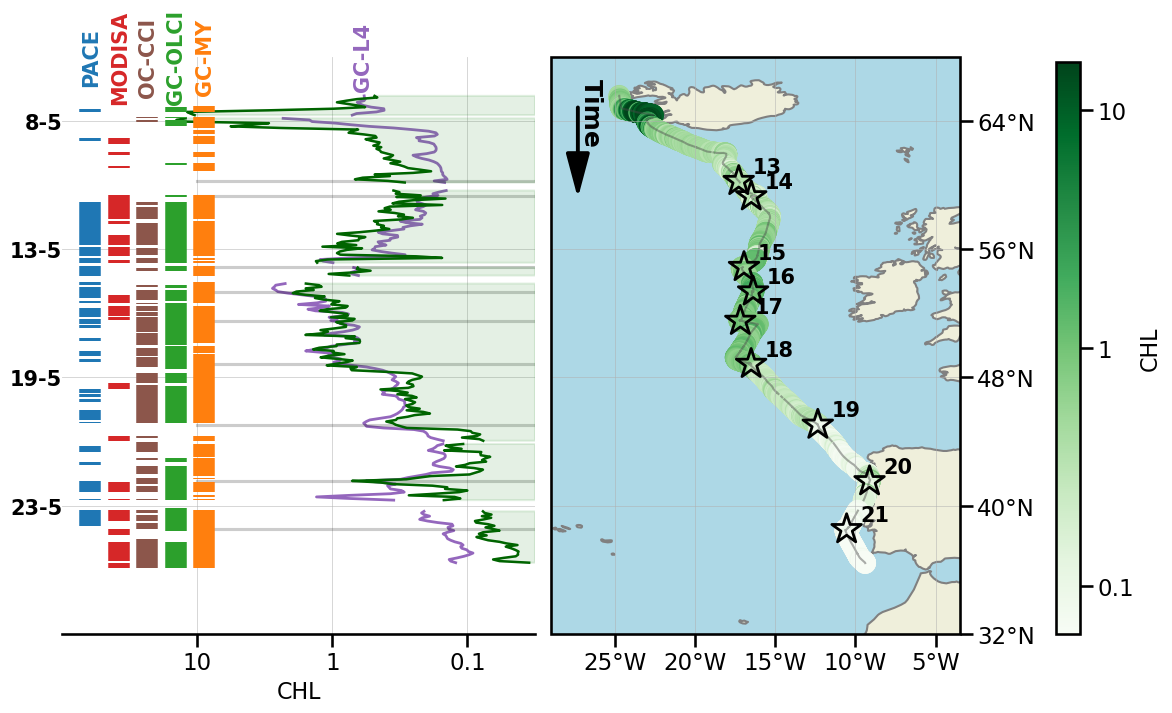

In [100]:
# ===================== SEGMENT 2: LATITUDINAL TRANSECT (North Atlantic) =====================

# --- inputs ---
extent = [-29, -3.5, 32, 68]
figsize = (12, 12/40*25)
time    = ["2025-05-04 06:00:00", "2025-05-24 06:00:00"]
res     = '10min'

# styling
vmin_fill  = -1.2   # smaller than before so the fill reaches lower CHL (≈0.063)
vmax       =  1.2
cmap       = 'Greens'
markercolor = 'black'
lw_markers  = 2
axis_label_fs = 16

# --- data subset + resample ---
ds2 = inline.sel(time=slice(time[0], time[1])).resample(time=res).mean()
ds2 = ds2.assign(logchl=np.log10(ds2.CHL))

# --- LATITUDINAL binning ---
lat_bin_size = 0.1
lat_edges = np.arange(extent[2], extent[3] + lat_bin_size, lat_bin_size)
gb_lat = ds2.groupby_bins('lat', lat_edges)
binned_lat = gb_lat.mean()

lat_centers_line = np.array([iv.mid for iv in binned_lat.lat_bins.values])
logchl_lat_mean  = binned_lat['logchl'].values
lat_centers_bins = (lat_edges[:-1] + lat_edges[1:]) / 2

# --- availability datasets ---
datasets = {
    "PACE":   xr.where(ds_pace['filt_cv']   > 0.15, np.nan, ds_pace['filt_m']),
    "MODISA": xr.where(ds_modisa['filt_cv'] > 0.15, np.nan, ds_modisa['filt_m']),
    "GC-OLCI":xr.where(ds_l3olci['filt_cv'] > 0.15, np.nan, ds_l3olci['filt_m']),
    "GC-MY":  xr.where(ds_l3['filt_cv']     > 0.15, np.nan, ds_l3['filt_m']),
    "OC-CCI":  xr.where(ds_oc_cci['filt_cv']     > 0.15, np.nan, ds_oc_cci['filt_m']),
}

colors = {
    "PACE":   "#1f77b4",
    "MODISA": "#d62728",
    "GC-OLCI":"#2ca02c",
    "GC-MY":  "#ff7f0e",
    "OC-CCI":  "tab:brown",
}

levels_x_left = {"PACE":0.06, "MODISA":0.12, "GC-OLCI":0.24, "GC-MY":0.30, "OC-CCI":0.18}
avail_lw = 15.5

# ---------------- layout ----------------
fig2 = plt.figure(figsize=figsize)
gs2  = GridSpec(1, 3, width_ratios=[28, 30, 1], wspace=-0.1)

# ===== MAP (right) =====
ax_map2 = fig2.add_subplot(gs2[0,1], projection=ccrs.PlateCarree())
ax_map2.set_extent(extent, crs=ccrs.PlateCarree())
ax_map2.add_feature(land, zorder=0)
ax_map2.set_facecolor("lightblue")

xticks2 = np.arange(np.ceil(extent[0]/5)*5, extent[1]+1, 5)
ax_map2.set_xticks(xticks2, crs=ccrs.PlateCarree())
ax_map2.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

yticks2 = np.arange(np.ceil(extent[2]/8)*8, extent[3]+1, 8)
ax_map2.set_yticks(yticks2, crs=ccrs.PlateCarree())
ax_map2.yaxis.tick_right()
ax_map2.tick_params(axis='y', left=False, right=True, labelright=True, labelleft=False)
ax_map2.yaxis.set_major_formatter(LatitudeFormatter())
ax_map2.grid(True, alpha=0.6, lw=0.6)



# scatter track + line
plot2 = ax_map2.scatter(ds2['lon'], ds2['lat'], transform=ccrs.PlateCarree(),
                        c=ds2['logchl'], cmap=cmap, vmin=vmin_fill, vmax=vmax, s=200)
ax_map2.plot(ds2['lon'], ds2['lat'], transform=ccrs.PlateCarree(),
             lw=1.5, color="#4a4a4a", alpha=0.45, zorder=1)

# ---- Time arrow: ~5° straight south, top-left of map ----
x_arrow = extent[0] + 1.7
y_start = extent[3] - 3.0
y_end   = y_start - 6.0

# Draw arrow
ax_map2.annotate(
    "", xy=(x_arrow, y_end), xytext=(x_arrow, y_start),
    xycoords=ccrs.PlateCarree()._as_mpl_transform(ax_map2),
    textcoords=ccrs.PlateCarree()._as_mpl_transform(ax_map2),
    arrowprops=dict(arrowstyle='-|>,head_width=0.4,head_length=1.5',
                    linewidth=2.8, color='black')
)

# Compute midpoint of the arrow
x_mid = x_arrow
y_mid = (y_start + y_end) / 2

# Add rotated label *near* the arrow
ax_map2.text(
    x_mid + 0.8,  # shift left (longitude direction)
    y_mid + 2.5,  # shift upward (latitude direction)
    "Time",
    transform=ccrs.PlateCarree(),
    ha='center', va='center',
    rotation=270,                # align with vertical arrow
    rotation_mode='anchor',
    fontsize=18, fontweight='bold', color='black'
)

# ===== COLORBAR (far right; no overlap with right lat labels) =====
cax2 = fig2.add_subplot(gs2[0,2])
pos2 = ax_map2.get_position()
gap  = 0.08  # push farther right to ensure clear of labels
#cax2.set_position([pos2.x1+gap, pos2.y0 + 0.02, 0.02, pos2.height*0.92])
cax2.set_position([pos2.x1+gap, pos2.y0, 0.02, pos2.height*0.99])
cbar2 = plt.colorbar(plot2, cax=cax2, shrink=0.7)
cbar2.set_ticks([-1, 0, 1])
cbar2.ax.set_yticklabels([0.1, 1, 10])  
cbar2.set_label('CHL', fontsize=axis_label_fs)

# ===== LAT-PROFILE (left) =====
ax_lat = fig2.add_subplot(gs2[0,0], sharey=ax_map2)

# CHL horizontal axis (inverted), padded; NO y ticks or spines
ax_lat.set_xlim(-1.5, 2) #vmin_fill
ax_lat.invert_xaxis()
ax_lat.margins(x=0.06, y=0.03)
#ax_lat.set_yticks([])  # ensure no stray y-ticks
ax_lat.tick_params(axis='y', left=False, labelleft=False)
for s in ax_lat.spines.values(): s.set_visible(False)
ax_lat.spines['bottom'].set_visible(True)

# clean fill & line
x_line = np.clip(logchl_lat_mean, -2, vmax*2.0)
ax_lat.fill_betweenx(lat_centers_line, -1.5, x_line,
                     alpha=0.12, color='forestgreen', zorder=5)
ax_lat.plot(x_line, lat_centers_line, lw=1.8, color='darkgreen', zorder=10)


#adding a GC-L4 line on top filt_m
ax_lat.plot(np.where(np.isnan(logchl_lat_mean),np.nan,np.log10(ds_l4['filt_m'].assign_coords({'time':inline_l4['time'].values}).sortby('time').sel(time=slice(time[0], time[1])).groupby_bins('lat',lat_edges).mean())), lat_centers_line, color='tab:purple',lw=2)
#ax_top.text(0,0.3, name, va='center', ha='left', fontsize=14, fontweight='bold', color='tab:purple', transform=ax_top.transAxes, clip_on=False)
ax_lat.text(-0.3, extent[3], 'GC-L4', rotation=90, rotation_mode='anchor', va='bottom', ha='center', fontsize=15, fontweight='bold', color='tab:purple', zorder=30)


# x ticks (log10) and label
ax_lat.set_xticks([-1, 0, 1])
ax_lat.set_xticklabels([0.1, 1, 10])
ax_lat.set_xlabel('CHL', fontsize=axis_label_fs)
ax_lat.grid(alpha=0.6, lw=0.6, linestyle='-')

# ---- Availability columns on the LEFT; labels aligned at same top y ----
xmin, xmax = ax_lat.get_xlim()
xrange = (xmax - xmin)
y_label_top = extent[3]   # single high y for all labels

for name, darr in datasets.items():
    sat_i = darr.sortby('time').sel(time=slice(time[0], time[1]))
    has_i = sat_i.groupby_bins('lat', lat_edges).count().values > 0
    x_i   = xmin + levels_x_left[name] * xrange

    seg_start = None
    for lat_c, ok in zip(lat_centers_bins, has_i):
        if ok and seg_start is None:
            seg_start = lat_c
        elif not ok and seg_start is not None:
            ax_lat.plot([x_i, x_i], [seg_start, lat_c],
                        color=colors[name], lw=avail_lw, solid_capstyle='butt', zorder=25)
            seg_start = None
    if seg_start is not None:
        ax_lat.plot([x_i, x_i], [seg_start, lat_centers_bins[-1]],
                    color=colors[name], lw=avail_lw, solid_capstyle='butt', zorder=25)

    ax_lat.text(x_i-0.08, y_label_top, name,
                rotation=90, rotation_mode='anchor',
                va='bottom', ha='center', fontsize=15, fontweight='bold',
                color=colors[name], zorder=30)

# ---- Time labels (dates) on the RIGHT side of the left panel ----
# Create a twin axis but immediately move everything to left
ax_lat_dates = ax_lat.twinx()

# This is the key line - set the axis to left side
ax_lat_dates.yaxis.tick_left()
ax_lat_dates.yaxis.set_label_position('left')

ax_lat_dates.set_ylim(ax_lat.get_ylim())

lat_marks = [64, 56, 48, 40]
date_labels = []
for la in lat_marks:
    idx = np.nanargmin(np.abs(ds2['lat'] - la).values)
    t = ds2['time'][idx]
    date_labels.append(f"{t.dt.day.values.item()}-{t.dt.month.values.item()}")

ax_lat_dates.set_yticks(lat_marks)
ax_lat_dates.set_yticklabels(date_labels, fontsize=15, fontweight='bold', color='black')

# Configure for left side
ax_lat_dates.tick_params(axis='y', left=True, right=False, labelleft=True)
ax_lat_dates.tick_params(axis='y', which='major', length=0,pad=0)
ax_lat.tick_params(axis='y', which='major', length=0)

for s in ax_lat_dates.spines.values(): s.set_visible(False)

# ===== CTD markers on the map =====
for k, v in merged.items():
    data2 = v[0]
    if (data2['time'].values >= np.datetime64(time[0])) and (data2['time'].values < np.datetime64(time[1])):
        if k == '04':
            lo = data2['lon']; la = data2['lat'] + 0.2
        elif k == '05':
            lo = data2['lon']; la = data2['lat'] - 0.2
        else:
            lo = data2['lon']; la = data2['lat']
        ax_map2.scatter(lo, la, transform=ccrs.PlateCarree(), marker='*', s=500,
                        color=markercolor, facecolor='none', zorder=100, linewidth=lw_markers)

        if k in offsets.keys():
            x,y=offsets[k]
        else:
            x=10;y=6
        #a bit of position manipulation for separating stars betters
    
        ax_map2.annotate(int(k), 
                   xy=(data2['lon'],data2['lat']), 
                   xytext=(x, y),  # Offset from the point
                   textcoords='offset points',
                   fontsize=15,
                   fontweight='bold',
                   color='black')

        ax_lat.plot([-2, 1],[data2['lat'].values.item(), data2['lat'].values.item()], color='black', alpha=0.2)


#plt.suptitle("Inline Chl-a, Satellite Matchups & CTD stations — North Atlantic",fontsize=22)
fig2.savefig('map_northatlantic_poster.png',format='png',dpi=600,bbox_inches='tight')
plt.show()


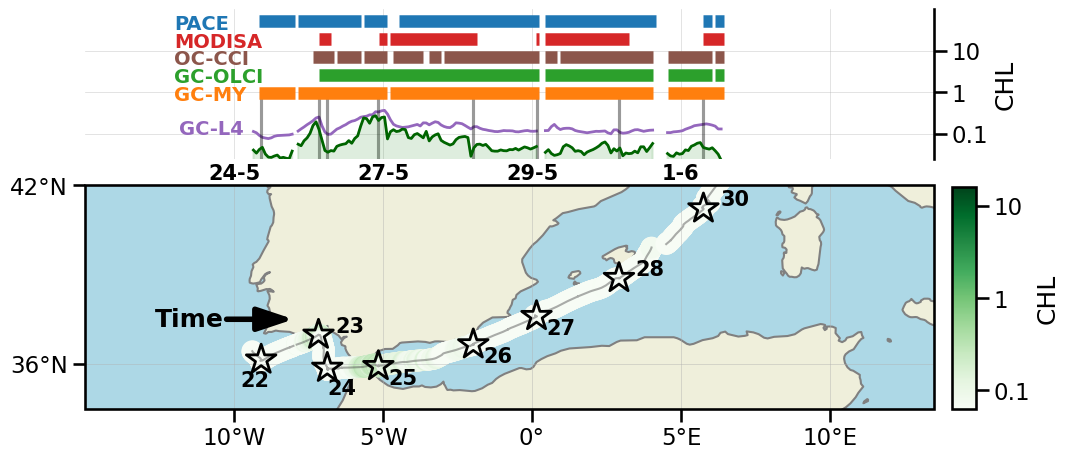

In [92]:
offsets={
'04':[3,10],
'05':[8,-15],
'22':[-15,-19],
'24':[0,-19],
'25':[7,-13],
'26':[7,-13],
'27':[7,-13],
}

#extent=[-13,10,33.5,44.5]
extent=[-15,13.5,34.5,42]
figsize=(12, 12/40*20)

vmin=-2
vmax=1.2

time=["2025-05-24 06:00:00","2025-06-03"]
res='10min'

# ---------- data subset + hourly mean (INLINE) ----------
ds = inline.sel(time=slice(time[0], time[1])).resample(time=res).mean()
ds = ds.assign(logchl=np.log10(ds.CHL))

# ---------- longitudinal binning ----------
bin_size = 0.1
lon_edges = np.arange(extent[0], extent[1] + bin_size, bin_size)
gb = ds.groupby_bins('lon', lon_edges)
binned = gb.mean()
lon_centers_line = np.array([iv.mid for iv in binned.lon_bins.values])
logchl_mean = binned['logchl'].values
lon_centers_bins = (lon_edges[:-1] + lon_edges[1:]) / 2

# ---------------- figure layout ----------------
fig = plt.figure(figsize=figsize)
#gs  = GridSpec(2, 2, height_ratios=[1, 2.5], width_ratios=[30, 1], hspace=-0.185, wspace=0.12)
gs  = GridSpec(2, 2, height_ratios=[1, 2.5], width_ratios=[30, 1], hspace=-0.185, wspace=0.12)

#xticks = np.arange(np.ceil(extent[0]/5)*5, extent[1]+1, 10)

# ===== MAP (bottom) =====
ax_map = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree())
ax_map.set_extent(extent, crs=ccrs.PlateCarree())
ax_map.add_feature(land, zorder=0)
ax_map.set_facecolor("lightblue")

# keep longitude ticks visible here
#ax_map.set_xticks(xticks, crs=ccrs.PlateCarree())
#ax_map.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

lon_ticks = [-10,-5,0,5,10]
ax_map.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax_map.xaxis.set_major_formatter(LongitudeFormatter())


yticks = np.arange(np.ceil(extent[2]/2)*2, extent[3]+1, 6)
ax_map.set_yticks(yticks, crs=ccrs.PlateCarree())
ax_map.yaxis.set_major_formatter(LatitudeFormatter())
ax_map.grid(True, alpha=0.5, lw=0.6)

plot = ax_map.scatter(ds['lon'], ds['lat'], transform=ccrs.PlateCarree(),
                      c=ds['logchl'], cmap=cmap, vmin=-1.2, vmax=1.2, s=200)
ax_map.plot(ds['lon'], ds['lat'], transform=ccrs.PlateCarree(),
            lw=1.5, color="#4a4a4a", alpha=0.45, zorder=1)

# colorbar
fig.subplots_adjust(top=0.90)

cax = fig.add_subplot(gs[1,1])
pos = ax_map.get_position()
#cax.set_position([pos.x1+0.015, pos.y0 + 0.02, 0.02, pos.height*0.92])
cax.set_position([pos.x1+0.015, pos.y0, 0.02, pos.height*0.99])
cbar = plt.colorbar(plot, cax=cax, shrink=0.7)
cbar.set_ticks([-1, 0, 1])
cbar.ax.set_yticklabels([0.1,1,10])
cbar.set_label('CHL')

# ===== TOP PANEL =====
ax_top = fig.add_subplot(gs[0,0], sharex=ax_map)
ax_top.set_ylim(-1.6, 2)

# main green line
ax_top.plot(lon_centers_line, logchl_mean, lw=2, color='darkgreen', zorder=10)
ax_top.fill_between(lon_centers_line, vmin, logchl_mean, alpha=0.15,
                    color='forestgreen', zorder=5)

#adding a GC-L4 line on top filt_m
ax_top.plot(lon_centers_line, np.where(np.isnan(logchl_mean),np.nan,np.log10(ds_l4['filt_m'].assign_coords({'time':inline_l4['time'].values}).sortby('time').sel(time=slice(time[0], time[1])).groupby_bins('lon',lon_edges).mean())) ,color='tab:purple',lw=2)
ax_top.text(0.11,0.2, 'GC-L4', va='center', ha='left', fontsize=14, fontweight='bold', color='tab:purple', transform=ax_top.transAxes, clip_on=False)


# right-side y-axis (fewer ticks)
ax_top.yaxis.set_label_position("right")
ax_top.yaxis.tick_right()
ax_top.set_ylabel('CHL')
ax_top.set_yticks([-1, 0, 1])
ax_top.set_yticklabels([0.1, 1, 10])
ax_top.grid(alpha=0.5, lw=0.5, linestyle='-')

# remove unwanted spines and x-ticks on the *primary* top axis
ax_top.spines['top'].set_visible(False)
ax_top.spines['left'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(axis='x', which='both', length=0, labelbottom=False)

# ---- PACE availability line ----
ymin, ymax = ax_top.get_ylim()
y_avail = ymin + 0.9 * (ymax - ymin)

# ------- multiple availability overlays (stacked) -------
# name -> DataArray mapping (each must have coords 'time','lon'; NaN = missing)
datasets = {
    "PACE": xr.where(ds_pace['filt_cv']>0.15,np.nan,ds_pace['filt_m']),                # already drawn above; keep or remove here
    "MODISA": xr.where(ds_modisa['filt_cv']>0.15,np.nan,ds_modisa['filt_m']), 
    "GC-OLCI": xr.where(ds_l3olci['filt_cv']>0.15,np.nan,ds_l3olci['filt_m']),
    "GC-MY": xr.where(ds_l3['filt_cv']>0.15,np.nan,ds_l3['filt_m']),         
    "OC-CCI": xr.where(ds_oc_cci['filt_cv']>0.15,np.nan,ds_oc_cci['filt_m']),         
}



# styling (colors and vertical offsets)
#colors  = {"PACE":"navy", "MODISA":"crimson", "GC-MY":"darkorange", "GC-OLCI":"teal"}
colors = {
    "PACE": "#1f77b4",   # blue
    "MODISA": "#d62728", # red
    "GC-OLCI": "#2ca02c",# green
    "GC-MY": "#ff7f0e",   # orange
    'OC-CCI':'tab:brown',
}

from matplotlib.transforms import blended_transform_factory

# use data coords for X, axes-fraction for Y
trans = blended_transform_factory(ax_top.transData, ax_top.transAxes)

# y-levels in axes-fraction coordinates (1.0 = top of panel)
steppi=0.08
levels_ax = {
    "PACE":   1.0-steppi,
    "MODISA": 0.9-steppi-0.02,
    "GC-OLCI":0.7-steppi-0.06,
    "GC-MY":  0.6-steppi-0.08,
    "OC-CCI":  0.8-steppi-0.04,
}
lw = 9  # thicker bars for visibility

for name, darr in datasets.items():
    sat_i = darr.sortby('time').sel(time=slice(time[0], time[1]))
    has_i = sat_i.groupby_bins('lon', lon_edges).count().values > 0
    y_i   = levels_ax[name]

    seg_start = None
    for lon, ok in zip(lon_centers_bins, has_i):
        if ok and seg_start is None:
            seg_start = lon
        elif not ok and seg_start is not None:
            ax_top.plot([seg_start, lon], [y_i, y_i],
                        color=colors[name], lw=lw, solid_capstyle='butt',
                        transform=trans, clip_on=False, zorder=30)
            seg_start = None
    if seg_start is not None:
        ax_top.plot([seg_start, lon_centers_bins[-1]], [y_i, y_i],
                    color=colors[name], lw=lw, solid_capstyle='butt',
                    transform=trans, clip_on=False, zorder=30)

    # short label on the left of each line (raised a bit higher)
    try:
        xlab = -12#lon_centers_bins[has_i][0] - 3
        ax_top.text(xlab, y_i - 0.015, name,
                    va='center', ha='left',
                    fontsize=14, fontweight='bold', color=colors[name],
                    transform=trans, clip_on=False)
    except IndexError:
        pass

# ---- DATES on a twin x-axis for the TOP panel only (clean + visible) ----
ax_date = ax_top.twiny()
ax_date.set_xlim(ax_top.get_xlim())

# put the ticks at the *bottom* of the top panel, but nudged upward into it
ax_date.xaxis.set_ticks_position('bottom')
for s in ax_date.spines.values():
    s.set_visible(False)                      # no spines at all
ax_date.tick_params(axis='x', top=False, bottom=True, length=0, pad=2)  # pad small => higher

# choose longitudes to annotate with their nearest dates
lon_marks = [-10, -5, 0, 5]
date_labels = []
for lon_val in lon_marks:
    idx = np.nanargmin(np.abs(ds['lon'] - lon_val).values)
    ti = ds.time[idx]
    date_labels.append(f"{ti.dt.day.values.item()}-{ti.dt.month.values.item()}")

ax_date.set_xticks(lon_marks)
# make dates pop (bold, slightly larger, with subtle white halo)
ax_date.set_xticklabels(
    date_labels,y=-0.01,
    fontsize=15, fontweight='bold', color='black',
    bbox=dict(facecolor='none', alpha=0.6, edgecolor='none', pad=1.5)
)

# keep only the right y-axis; drop the rest
ax_top.spines['top'].set_visible(False)
ax_top.spines['left'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(axis='x', which='both', length=0, labelbottom=False)


# ===== CTD markers =====
for i,(k,v) in enumerate(merged.items()):
    data2 = v[0]
    if (data2['time'].values >= np.datetime64(time[0])) and (data2['time'].values < np.datetime64(time[1])):
        if k == '04':
            lo = data2['lon']; la = data2['lat'] + 0.2
        elif k == '05':
            lo = data2['lon']; la = data2['lat'] - 0.2
        else:
            lo = data2['lon']; la = data2['lat']
        ax_map.scatter(lo, la, transform=ccrs.PlateCarree(), marker='*', s=500,
                       color=markercolor, facecolor='none', zorder=100, linewidth=2)
        x_off, y_off = offsets.get(k, (12, 2))
        ax_map.annotate(int(k), xy=(data2['lon'], data2['lat']),
                        xytext=(x_off, y_off), textcoords='offset points',
                        fontsize=15, fontweight='bold', color='black')
        ax_top.plot([data2['lon'].values.item(), data2['lon'].values.item()],
                    #[-2, 0.4], color='black', alpha=0.4)
                    [-2, 0], color='black', alpha=0.4)

# ===== Time arrow on map =====
ax_map.annotate(
    "Time",
    xy=(-8, 37.5), xytext=(-11.5,37.5),
    xycoords=ccrs.PlateCarree()._as_mpl_transform(ax_map),
    textcoords=ccrs.PlateCarree()._as_mpl_transform(ax_map),
    ha='center', va='center',
    fontsize=18, fontweight='bold', color='black',
    arrowprops=dict(arrowstyle='-|>,head_width=0.4,head_length=1.2',
                    linewidth=4, color='black', shrinkA=0, shrinkB=0)
)

#plt.suptitle("Inline Chl-a, Satellite Matchups & CTD stations — Med. Sea",fontsize=22,y=0.96)
fig.savefig('map_med_poster.png',format='png',dpi=600,bbox_inches='tight')
plt.show()

# PREVIOUS MAP VERSIONS (narrower)

# North Atlantic

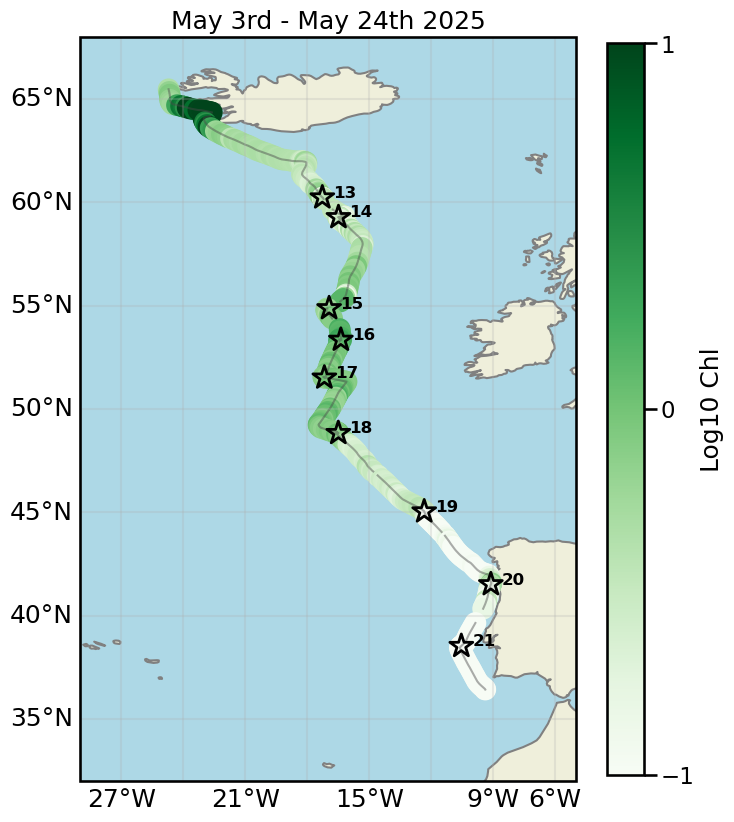

In [21]:
extent=[-29,-5,32,68]
figsize=(8, 10)

time=["2025-05-04 06:00:00","2025-05-24 06:00:00"]
#time=["2025-05-05","2025-05-20"]
#time=["2025-05-20","2025-06-03"]


data=inline.sel(time=slice(time[0],time[1])).resample(time='h').mean()
step=1
vmin=-1
vmax=1
size=200
cmap='Greens'
#markercolor='white'
#markercolor='lightgray'
markercolor='black'
lw=2
<
offsets={
'04':[3,10],
'05':[8,-15],
'22':[-15,-15],
'24':[0,-15],
'25':[7,-13],
'26':[7,-13],
'27':[7,-13],
}

fig = plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(land,zorder=0)
#ax.set_facecolor("#e8f6ff")  # light blue ocean
ax.set_facecolor("lightblue")  # light blue ocean
gl=ax.gridlines(draw_labels=["bottom", "left"], alpha=0.25)

plot=ax.scatter(data['lon'][::step],data['lat'][::step],transform=ccrs.PlateCarree(),c=np.log10(data['CHL'][::step]),cmap=cmap,vmin=vmin,vmax=vmax,s=size)

ax.plot(data['lon'], data['lat'], transform=ccrs.PlateCarree(),
        lw=1.5, color="#4a4a4a", alpha=0.45, zorder=1)

cbar = plt.colorbar(plot, shrink=0.95)

cbar.set_ticks([vmin,0,vmax])

cbar.set_label('Log10 Chl')
plt.title('May 3rd - May 24th 2025')

#################### plot CTD markers and annotations ####################
for i,(k,v) in enumerate(merged.items()):
    #select first cast (doesn't matter which one we take)
    data2=v[0]
    if (data2['time'].values>=np.datetime64(time[0])) and (data2['time'].values<np.datetime64(time[1])):
    
        if k=='04':
            lo=data2['lon'];la=data2['lat']+0.2     
        elif k=='05':
            lo=data2['lon'];la=data2['lat']-0.2
        else:
            lo=data2['lon'];la=data2['lat']
    
        ax.scatter(lo,la,transform=ccrs.PlateCarree(),marker='*',s=300,color=markercolor,facecolor='none',zorder=100,linewidth=lw)
    
        if k in offsets.keys():
            x,y=offsets[k]
        else:
            x=8;y=0
        #a bit of position manipulation for separating stars betters
    
        ax.annotate(int(k), 
                   xy=(data2['lon'],data2['lat']), 
                   xytext=(x, y),  # Offset from the point
                   textcoords='offset points',
                   fontsize=12,
                   fontweight='bold',
                   color='black')

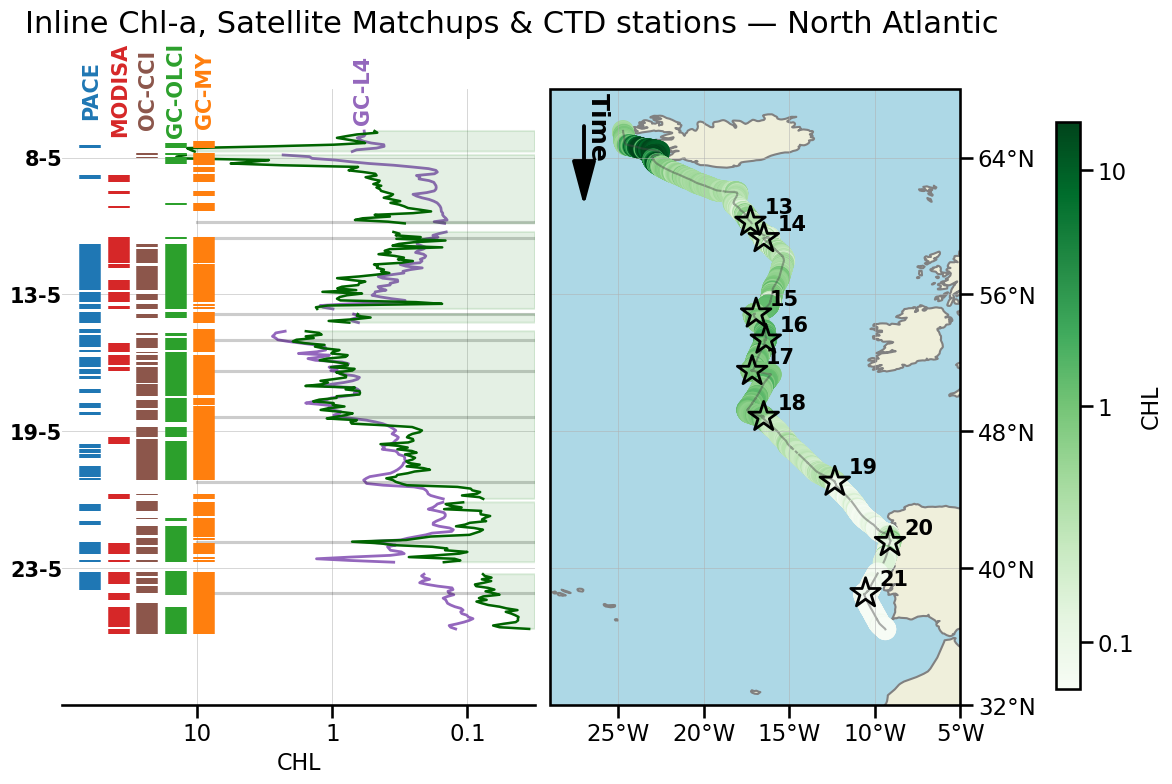

In [97]:
# ===================== SEGMENT 2: LATITUDINAL TRANSECT (North Atlantic) =====================

# --- inputs ---
extent = [-29, -5, 32, 68]
figsize = (12, 8)
time    = ["2025-05-04 06:00:00", "2025-05-24 06:00:00"]
res     = '10min'

# styling
vmin_fill  = -1.2   # smaller than before so the fill reaches lower CHL (≈0.063)
vmax       =  1.2
cmap       = 'Greens'
markercolor = 'black'
lw_markers  = 2
axis_label_fs = 16

# --- data subset + resample ---
ds2 = inline.sel(time=slice(time[0], time[1])).resample(time=res).mean()
ds2 = ds2.assign(logchl=np.log10(ds2.CHL))

# --- LATITUDINAL binning ---
lat_bin_size = 0.1
lat_edges = np.arange(extent[2], extent[3] + lat_bin_size, lat_bin_size)
gb_lat = ds2.groupby_bins('lat', lat_edges)
binned_lat = gb_lat.mean()

lat_centers_line = np.array([iv.mid for iv in binned_lat.lat_bins.values])
logchl_lat_mean  = binned_lat['logchl'].values
lat_centers_bins = (lat_edges[:-1] + lat_edges[1:]) / 2

# --- availability datasets ---
datasets = {
    "PACE":   xr.where(ds_pace['filt_cv']   > 0.15, np.nan, ds_pace['filt_m']),
    "MODISA": xr.where(ds_modisa['filt_cv'] > 0.15, np.nan, ds_modisa['filt_m']),
    "GC-OLCI":xr.where(ds_l3olci['filt_cv'] > 0.15, np.nan, ds_l3olci['filt_m']),
    "GC-MY":  xr.where(ds_l3['filt_cv']     > 0.15, np.nan, ds_l3['filt_m']),
    "OC-CCI":  xr.where(ds_oc_cci['filt_cv']     > 0.15, np.nan, ds_oc_cci['filt_m']),
}

colors = {
    "PACE":   "#1f77b4",
    "MODISA": "#d62728",
    "GC-OLCI":"#2ca02c",
    "GC-MY":  "#ff7f0e",
    "OC-CCI":  "tab:brown",
}

levels_x_left = {"PACE":0.06, "MODISA":0.12, "GC-OLCI":0.24, "GC-MY":0.30, "OC-CCI":0.18}
avail_lw = 15.5

# ---------------- layout ----------------
fig2 = plt.figure(figsize=figsize)
gs2  = GridSpec(1, 3, width_ratios=[28, 30, 1], wspace=-0.1)

# ===== MAP (right) =====
ax_map2 = fig2.add_subplot(gs2[0,1], projection=ccrs.PlateCarree())
ax_map2.set_extent(extent, crs=ccrs.PlateCarree())
ax_map2.add_feature(land, zorder=0)
ax_map2.set_facecolor("lightblue")

xticks2 = np.arange(np.ceil(extent[0]/5)*5, extent[1]+1, 5)
ax_map2.set_xticks(xticks2, crs=ccrs.PlateCarree())
ax_map2.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

yticks2 = np.arange(np.ceil(extent[2]/8)*8, extent[3]+1, 8)
ax_map2.set_yticks(yticks2, crs=ccrs.PlateCarree())
ax_map2.yaxis.tick_right()
ax_map2.tick_params(axis='y', left=False, right=True, labelright=True, labelleft=False)
ax_map2.yaxis.set_major_formatter(LatitudeFormatter())
ax_map2.grid(True, alpha=0.6, lw=0.6)



# scatter track + line
plot2 = ax_map2.scatter(ds2['lon'], ds2['lat'], transform=ccrs.PlateCarree(),
                        c=ds2['logchl'], cmap=cmap, vmin=vmin_fill, vmax=vmax, s=200)
ax_map2.plot(ds2['lon'], ds2['lat'], transform=ccrs.PlateCarree(),
             lw=1.5, color="#4a4a4a", alpha=0.45, zorder=1)

# ---- Time arrow: ~5° straight south, top-left of map ----
"""
x_arrow = extent[0] + 2.0
y_start = extent[3] - 2.0
y_end   = y_start - 5.0
ax_map2.annotate(
    "", xy=(x_arrow, y_end), xytext=(x_arrow, y_start),
    xycoords=ccrs.PlateCarree()._as_mpl_transform(ax_map2),
    textcoords=ccrs.PlateCarree()._as_mpl_transform(ax_map2),
    arrowprops=dict(arrowstyle='-|>,head_width=0.4,head_length=1.5',
                    linewidth=2.8, color='black',)
)
ax_map2.text(x_arrow, y_start + 0.3, "Time",
             transform=ccrs.PlateCarree(), ha='center', va='bottom',
             fontsize=15, fontweight='bold', color='black')
"""
# ---- Time arrow: ~5° straight south, top-left of map ----
x_arrow = extent[0] + 2.0
y_start = extent[3] - 2.0
y_end   = y_start - 5.0

# Draw arrow
ax_map2.annotate(
    "", xy=(x_arrow, y_end), xytext=(x_arrow, y_start),
    xycoords=ccrs.PlateCarree()._as_mpl_transform(ax_map2),
    textcoords=ccrs.PlateCarree()._as_mpl_transform(ax_map2),
    arrowprops=dict(arrowstyle='-|>,head_width=0.4,head_length=1.5',
                    linewidth=2.8, color='black')
)

# Compute midpoint of the arrow
x_mid = x_arrow
y_mid = (y_start + y_end) / 2

# Add rotated label *near* the arrow
ax_map2.text(
    x_mid + 0.8,  # shift left (longitude direction)
    y_mid + 2.3,  # shift upward (latitude direction)
    "Time",
    transform=ccrs.PlateCarree(),
    ha='center', va='center',
    rotation=270,                # align with vertical arrow
    rotation_mode='anchor',
    fontsize=18, fontweight='bold', color='black'
)

# ===== COLORBAR (far right; no overlap with right lat labels) =====
cax2 = fig2.add_subplot(gs2[0,2])
pos2 = ax_map2.get_position()
gap  = 0.08  # push farther right to ensure clear of labels
cax2.set_position([pos2.x1+gap, pos2.y0 + 0.02, 0.02, pos2.height*0.92])
cbar2 = plt.colorbar(plot2, cax=cax2, shrink=0.7)
cbar2.set_ticks([-1, 0, 1])
cbar2.ax.set_yticklabels([0.1, 1, 10])  
cbar2.set_label('CHL', fontsize=axis_label_fs)

# ===== LAT-PROFILE (left) =====
ax_lat = fig2.add_subplot(gs2[0,0], sharey=ax_map2)

# CHL horizontal axis (inverted), padded; NO y ticks or spines
ax_lat.set_xlim(-1.5, 2) #vmin_fill
ax_lat.invert_xaxis()
ax_lat.margins(x=0.06, y=0.03)
#ax_lat.set_yticks([])  # ensure no stray y-ticks
ax_lat.tick_params(axis='y', left=False, labelleft=False)
for s in ax_lat.spines.values(): s.set_visible(False)
ax_lat.spines['bottom'].set_visible(True)

# clean fill & line
x_line = np.clip(logchl_lat_mean, -2, vmax*2.0)
ax_lat.fill_betweenx(lat_centers_line, -1.5, x_line,
                     alpha=0.12, color='forestgreen', zorder=5)
ax_lat.plot(x_line, lat_centers_line, lw=1.8, color='darkgreen', zorder=10)


#adding a GC-L4 line on top filt_m
ax_lat.plot(np.where(np.isnan(logchl_lat_mean),np.nan,np.log10(ds_l4['filt_m'].assign_coords({'time':inline_l4['time'].values}).sortby('time').sel(time=slice(time[0], time[1])).groupby_bins('lat',lat_edges).mean())), lat_centers_line, color='tab:purple',lw=2)
#ax_top.text(0,0.3, name, va='center', ha='left', fontsize=14, fontweight='bold', color='tab:purple', transform=ax_top.transAxes, clip_on=False)
ax_lat.text(-0.3, extent[3], 'GC-L4', rotation=90, rotation_mode='anchor', va='bottom', ha='center', fontsize=15, fontweight='bold', color='tab:purple', zorder=30)


# x ticks (log10) and label
ax_lat.set_xticks([-1, 0, 1])
ax_lat.set_xticklabels([0.1, 1, 10])
ax_lat.set_xlabel('CHL', fontsize=axis_label_fs)
ax_lat.grid(alpha=0.6, lw=0.6, linestyle='-')

# ---- Availability columns on the LEFT; labels aligned at same top y ----
xmin, xmax = ax_lat.get_xlim()
xrange = (xmax - xmin)
y_label_top = extent[3]   # single high y for all labels

for name, darr in datasets.items():
    sat_i = darr.sortby('time').sel(time=slice(time[0], time[1]))
    has_i = sat_i.groupby_bins('lat', lat_edges).count().values > 0
    x_i   = xmin + levels_x_left[name] * xrange

    seg_start = None
    for lat_c, ok in zip(lat_centers_bins, has_i):
        if ok and seg_start is None:
            seg_start = lat_c
        elif not ok and seg_start is not None:
            ax_lat.plot([x_i, x_i], [seg_start, lat_c],
                        color=colors[name], lw=avail_lw, solid_capstyle='butt', zorder=25)
            seg_start = None
    if seg_start is not None:
        ax_lat.plot([x_i, x_i], [seg_start, lat_centers_bins[-1]],
                    color=colors[name], lw=avail_lw, solid_capstyle='butt', zorder=25)

    ax_lat.text(x_i-0.08, y_label_top, name,
                rotation=90, rotation_mode='anchor',
                va='bottom', ha='center', fontsize=15, fontweight='bold',
                color=colors[name], zorder=30)

# ---- Time labels (dates) on the RIGHT side of the left panel ----
# Create a twin axis but immediately move everything to left
ax_lat_dates = ax_lat.twinx()

# This is the key line - set the axis to left side
ax_lat_dates.yaxis.tick_left()
ax_lat_dates.yaxis.set_label_position('left')

ax_lat_dates.set_ylim(ax_lat.get_ylim())

lat_marks = [64, 56, 48, 40]
date_labels = []
for la in lat_marks:
    idx = np.nanargmin(np.abs(ds2['lat'] - la).values)
    t = ds2['time'][idx]
    date_labels.append(f"{t.dt.day.values.item()}-{t.dt.month.values.item()}")

ax_lat_dates.set_yticks(lat_marks)
ax_lat_dates.set_yticklabels(date_labels, fontsize=15, fontweight='bold', color='black')

# Configure for left side
ax_lat_dates.tick_params(axis='y', left=True, right=False, labelleft=True)
ax_lat_dates.tick_params(axis='y', which='major', length=0,pad=0)
ax_lat.tick_params(axis='y', which='major', length=0)

for s in ax_lat_dates.spines.values(): s.set_visible(False)

# ===== CTD markers on the map =====
for k, v in merged.items():
    data2 = v[0]
    if (data2['time'].values >= np.datetime64(time[0])) and (data2['time'].values < np.datetime64(time[1])):
        if k == '04':
            lo = data2['lon']; la = data2['lat'] + 0.2
        elif k == '05':
            lo = data2['lon']; la = data2['lat'] - 0.2
        else:
            lo = data2['lon']; la = data2['lat']
        ax_map2.scatter(lo, la, transform=ccrs.PlateCarree(), marker='*', s=500,
                        color=markercolor, facecolor='none', zorder=100, linewidth=lw_markers)

        if k in offsets.keys():
            x,y=offsets[k]
        else:
            x=10;y=6
        #a bit of position manipulation for separating stars betters
    
        ax_map2.annotate(int(k), 
                   xy=(data2['lon'],data2['lat']), 
                   xytext=(x, y),  # Offset from the point
                   textcoords='offset points',
                   fontsize=15,
                   fontweight='bold',
                   color='black')

        ax_lat.plot([-2, 1],[data2['lat'].values.item(), data2['lat'].values.item()], color='black', alpha=0.2)


plt.suptitle("Inline Chl-a, Satellite Matchups & CTD stations — North Atlantic",fontsize=22)
fig2.savefig('map_northatlantic.png',format='png',dpi=300,bbox_inches='tight')
plt.show()


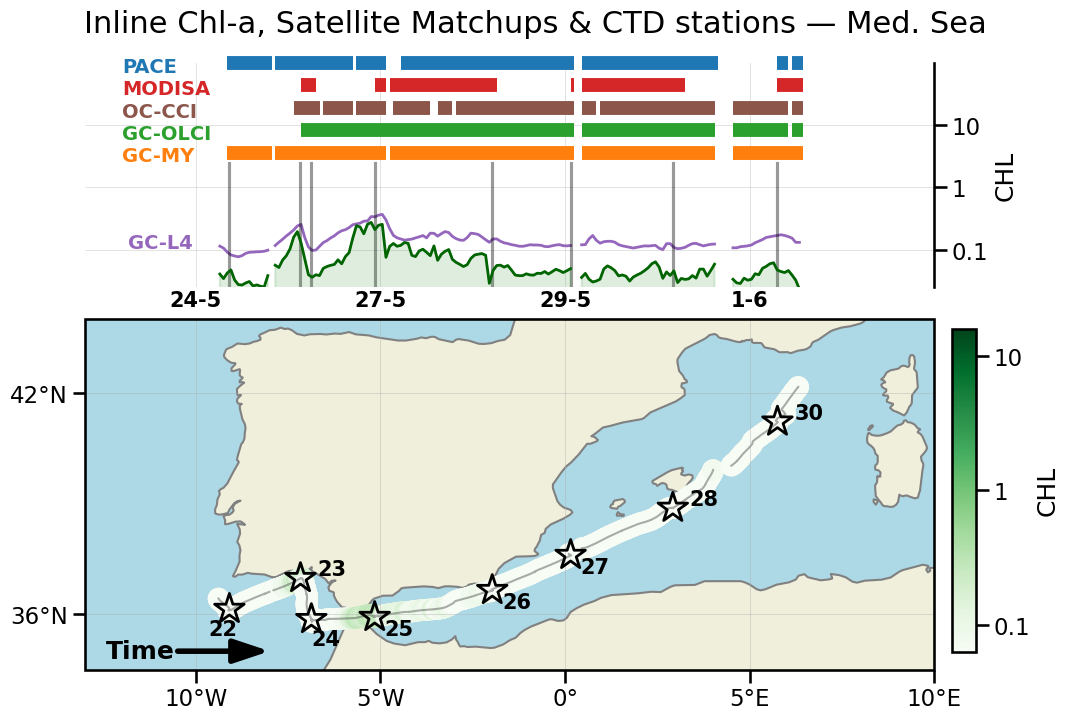

In [38]:


offsets={
'04':[3,10],
'05':[8,-15],
'22':[-15,-19],
'24':[0,-19],
'25':[7,-13],
'26':[7,-13],
'27':[7,-13],
}

#extent=[-13,10,33.5,44.5]
extent=[-13,10,34.5,44]
figsize=(12, 9)

vmin=-2
vmax=1.2

time=["2025-05-24 06:00:00","2025-06-03"]
res='10min'

# ---------- data subset + hourly mean (INLINE) ----------
ds = inline.sel(time=slice(time[0], time[1])).resample(time=res).mean()
ds = ds.assign(logchl=np.log10(ds.CHL))

# ---------- longitudinal binning ----------
bin_size = 0.1
lon_edges = np.arange(extent[0], extent[1] + bin_size, bin_size)
gb = ds.groupby_bins('lon', lon_edges)
binned = gb.mean()
lon_centers_line = np.array([iv.mid for iv in binned.lon_bins.values])
logchl_mean = binned['logchl'].values
lon_centers_bins = (lon_edges[:-1] + lon_edges[1:]) / 2

# ---------------- figure layout ----------------
fig = plt.figure(figsize=figsize)
gs  = GridSpec(2, 2, height_ratios=[1, 2.5], width_ratios=[30, 1], hspace=-0.185, wspace=0.12)

#xticks = np.arange(np.ceil(extent[0]/5)*5, extent[1]+1, 10)

# ===== MAP (bottom) =====
ax_map = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree())
ax_map.set_extent(extent, crs=ccrs.PlateCarree())
ax_map.add_feature(land, zorder=0)
ax_map.set_facecolor("lightblue")

# keep longitude ticks visible here
#ax_map.set_xticks(xticks, crs=ccrs.PlateCarree())
#ax_map.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

lon_ticks = [-10,-5,0,5,10]
ax_map.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax_map.xaxis.set_major_formatter(LongitudeFormatter())


yticks = np.arange(np.ceil(extent[2]/2)*2, extent[3]+1, 6)
ax_map.set_yticks(yticks, crs=ccrs.PlateCarree())
ax_map.yaxis.set_major_formatter(LatitudeFormatter())
ax_map.grid(True, alpha=0.5, lw=0.6)

plot = ax_map.scatter(ds['lon'], ds['lat'], transform=ccrs.PlateCarree(),
                      c=ds['logchl'], cmap=cmap, vmin=-1.2, vmax=1.2, s=200)
ax_map.plot(ds['lon'], ds['lat'], transform=ccrs.PlateCarree(),
            lw=1.5, color="#4a4a4a", alpha=0.45, zorder=1)

# colorbar
fig.subplots_adjust(top=0.90)

cax = fig.add_subplot(gs[1,1])
pos = ax_map.get_position()
cax.set_position([pos.x1+0.015, pos.y0 + 0.02, 0.02, pos.height*0.92])
cbar = plt.colorbar(plot, cax=cax, shrink=0.7)
cbar.set_ticks([-1, 0, 1])
cbar.ax.set_yticklabels([0.1,1,10])
cbar.set_label('CHL')

# ===== TOP PANEL =====
ax_top = fig.add_subplot(gs[0,0], sharex=ax_map)
ax_top.set_ylim(-1.6, 2)

# main green line
ax_top.plot(lon_centers_line, logchl_mean, lw=2, color='darkgreen', zorder=10)
ax_top.fill_between(lon_centers_line, vmin, logchl_mean, alpha=0.15,
                    color='forestgreen', zorder=5)

#adding a GC-L4 line on top filt_m
ax_top.plot(lon_centers_line, np.where(np.isnan(logchl_mean),np.nan,np.log10(ds_l4['filt_m'].assign_coords({'time':inline_l4['time'].values}).sortby('time').sel(time=slice(time[0], time[1])).groupby_bins('lon',lon_edges).mean())) ,color='tab:purple',lw=2)
ax_top.text(0.05,0.2, 'GC-L4', va='center', ha='left', fontsize=14, fontweight='bold', color='tab:purple', transform=ax_top.transAxes, clip_on=False)


# right-side y-axis (fewer ticks)
ax_top.yaxis.set_label_position("right")
ax_top.yaxis.tick_right()
ax_top.set_ylabel('CHL')
ax_top.set_yticks([-1, 0, 1])
ax_top.set_yticklabels([0.1, 1, 10])
ax_top.grid(alpha=0.5, lw=0.5, linestyle='-')

# remove unwanted spines and x-ticks on the *primary* top axis
ax_top.spines['top'].set_visible(False)
ax_top.spines['left'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(axis='x', which='both', length=0, labelbottom=False)

# ---- PACE availability line ----
ymin, ymax = ax_top.get_ylim()
y_avail = ymin + 0.9 * (ymax - ymin)

# ------- multiple availability overlays (stacked) -------
# name -> DataArray mapping (each must have coords 'time','lon'; NaN = missing)
datasets = {
    "PACE": xr.where(ds_pace['filt_cv']>0.15,np.nan,ds_pace['filt_m']),                # already drawn above; keep or remove here
    "MODISA": xr.where(ds_modisa['filt_cv']>0.15,np.nan,ds_modisa['filt_m']), 
    "GC-OLCI": xr.where(ds_l3olci['filt_cv']>0.15,np.nan,ds_l3olci['filt_m']),
    "GC-MY": xr.where(ds_l3['filt_cv']>0.15,np.nan,ds_l3['filt_m']),         
    "OC-CCI": xr.where(ds_oc_cci['filt_cv']>0.15,np.nan,ds_oc_cci['filt_m']),         
}



# styling (colors and vertical offsets)
#colors  = {"PACE":"navy", "MODISA":"crimson", "GC-MY":"darkorange", "GC-OLCI":"teal"}
colors = {
    "PACE": "#1f77b4",   # blue
    "MODISA": "#d62728", # red
    "GC-OLCI": "#2ca02c",# green
    "GC-MY": "#ff7f0e",   # orange
    'OC-CCI':'tab:brown',
}

"""
levels  = {"PACE":0.9,   "MODISA":0.81,      "GC-MY":0.63,        "GC-OLCI":0.72}  # fraction of axis height
lw = 9  # thickness of the availability bars

for name, darr in datasets.items():
    sat_i = darr.sortby('time').sel(time=slice(time[0], time[1]))
    has_i = sat_i.groupby_bins('lon', lon_edges).count().values > 0
    y_i   = ymin + levels[name] * (ymax - ymin)

    seg_start = None
    for lon, ok in zip(lon_centers_bins, has_i):
        if ok and seg_start is None:
            seg_start = lon
        elif not ok and seg_start is not None:
            ax_top.plot([seg_start, lon], [y_i, y_i],
                        color=colors[name], lw=lw, solid_capstyle='butt', zorder=25)
            seg_start = None
    if seg_start is not None:
        ax_top.plot([seg_start, lon_centers_bins[-1]], [y_i, y_i],
                    color=colors[name], lw=lw, solid_capstyle='butt', zorder=25)

    # optional tiny label near the right edge of each line
    try:
        xlab = lon_centers_bins[has_i][-1] + 0.5
        ax_top.text(xlab, y_i, name, va='center', ha='left',
                    fontsize=12, fontweight='bold', color=colors[name])
    except IndexError:
        pass  # no availability for this dataset
"""
from matplotlib.transforms import blended_transform_factory

# use data coords for X, axes-fraction for Y
trans = blended_transform_factory(ax_top.transData, ax_top.transAxes)

# y-levels in axes-fraction coordinates (1.0 = top of panel)
levels_ax = {
    "PACE":   1.0,
    "MODISA": 0.9,
    "GC-OLCI":0.7,
    "GC-MY":  0.6,
    "OC-CCI":  0.8,
}
lw = 10  # thicker bars for visibility

for name, darr in datasets.items():
    sat_i = darr.sortby('time').sel(time=slice(time[0], time[1]))
    has_i = sat_i.groupby_bins('lon', lon_edges).count().values > 0
    y_i   = levels_ax[name]

    seg_start = None
    for lon, ok in zip(lon_centers_bins, has_i):
        if ok and seg_start is None:
            seg_start = lon
        elif not ok and seg_start is not None:
            ax_top.plot([seg_start, lon], [y_i, y_i],
                        color=colors[name], lw=lw, solid_capstyle='butt',
                        transform=trans, clip_on=False, zorder=30)
            seg_start = None
    if seg_start is not None:
        ax_top.plot([seg_start, lon_centers_bins[-1]], [y_i, y_i],
                    color=colors[name], lw=lw, solid_capstyle='butt',
                    transform=trans, clip_on=False, zorder=30)

    # short label on the left of each line (raised a bit higher)
    try:
        xlab = -12#lon_centers_bins[has_i][0] - 3
        ax_top.text(xlab, y_i - 0.015, name,
                    va='center', ha='left',
                    fontsize=14, fontweight='bold', color=colors[name],
                    transform=trans, clip_on=False)
    except IndexError:
        pass

# ---- DATES on a twin x-axis for the TOP panel only (clean + visible) ----
ax_date = ax_top.twiny()
ax_date.set_xlim(ax_top.get_xlim())

# put the ticks at the *bottom* of the top panel, but nudged upward into it
ax_date.xaxis.set_ticks_position('bottom')
for s in ax_date.spines.values():
    s.set_visible(False)                      # no spines at all
ax_date.tick_params(axis='x', top=False, bottom=True, length=0, pad=2)  # pad small => higher

# choose longitudes to annotate with their nearest dates
lon_marks = [-10, -5, 0, 5]
date_labels = []
for lon_val in lon_marks:
    idx = np.nanargmin(np.abs(ds['lon'] - lon_val).values)
    ti = ds.time[idx]
    date_labels.append(f"{ti.dt.day.values.item()}-{ti.dt.month.values.item()}")

ax_date.set_xticks(lon_marks)
# make dates pop (bold, slightly larger, with subtle white halo)
ax_date.set_xticklabels(
    date_labels,
    fontsize=15, fontweight='bold', color='black',
    bbox=dict(facecolor='none', alpha=0.6, edgecolor='none', pad=1.5)
)

# keep only the right y-axis; drop the rest
ax_top.spines['top'].set_visible(False)
ax_top.spines['left'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(axis='x', which='both', length=0, labelbottom=False)


# ===== CTD markers =====
for i,(k,v) in enumerate(merged.items()):
    data2 = v[0]
    if (data2['time'].values >= np.datetime64(time[0])) and (data2['time'].values < np.datetime64(time[1])):
        if k == '04':
            lo = data2['lon']; la = data2['lat'] + 0.2
        elif k == '05':
            lo = data2['lon']; la = data2['lat'] - 0.2
        else:
            lo = data2['lon']; la = data2['lat']
        ax_map.scatter(lo, la, transform=ccrs.PlateCarree(), marker='*', s=500,
                       color=markercolor, facecolor='none', zorder=100, linewidth=2)
        x_off, y_off = offsets.get(k, (12, 2))
        ax_map.annotate(int(k), xy=(data2['lon'], data2['lat']),
                        xytext=(x_off, y_off), textcoords='offset points',
                        fontsize=15, fontweight='bold', color='black')
        ax_top.plot([data2['lon'].values.item(), data2['lon'].values.item()],
                    [-2, 0.4], color='black', alpha=0.4)

# ===== Time arrow on map =====
ax_map.annotate(
    "Time",
    xy=(-8, 35), xytext=(-11.5,35),
    xycoords=ccrs.PlateCarree()._as_mpl_transform(ax_map),
    textcoords=ccrs.PlateCarree()._as_mpl_transform(ax_map),
    ha='center', va='center',
    fontsize=18, fontweight='bold', color='black',
    arrowprops=dict(arrowstyle='-|>,head_width=0.4,head_length=1.2',
                    linewidth=4, color='black', shrinkA=0, shrinkB=0)
)

plt.suptitle("Inline Chl-a, Satellite Matchups & CTD stations — Med. Sea",fontsize=22,y=0.96)
fig.savefig('map_med.png',format='png',dpi=300,bbox_inches='tight')
plt.show()

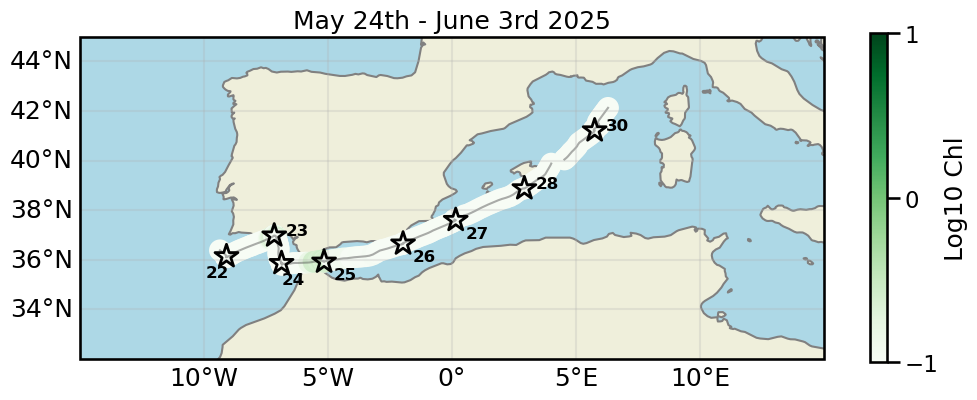

In [247]:
extent=[-15,15,32,45]
figsize=(12, 4.5)

time=["2025-05-24 06:00:00","2025-06-03"]
#time=["2025-05-05","2025-05-20"]
#time=["2025-05-20","2025-06-03"]


data=inline.sel(time=slice(time[0],time[1])).resample(time='h').mean()
step=1
vmin=-1
vmax=1
size=200
cmap='Greens'
#markercolor='white'
#markercolor='lightgray'
markercolor='black'
lw=2

offsets={
'04':[3,10],
'05':[8,-15],
'22':[-15,-15],
'24':[0,-15],
'25':[7,-13],
'26':[7,-13],
'27':[7,-13],
}

fig = plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(land,zorder=0)
#ax.set_facecolor("#e8f6ff")  # light blue ocean
ax.set_facecolor("lightblue")  # light blue ocean
gl=ax.gridlines(draw_labels=["bottom", "left"], alpha=0.25)

plot=ax.scatter(data['lon'][::step],data['lat'][::step],transform=ccrs.PlateCarree(),c=np.log10(data['CHL'][::step]),cmap=cmap,vmin=vmin,vmax=vmax,s=size)

ax.plot(data['lon'], data['lat'], transform=ccrs.PlateCarree(),
        lw=1.5, color="#4a4a4a", alpha=0.45, zorder=1)

cbar = plt.colorbar(plot, shrink=0.95)

cbar.set_ticks([vmin,0,vmax])

cbar.set_label('Log10 Chl')
plt.title('May 24th - June 3rd 2025')

#################### plot CTD markers and annotations ####################
for i,(k,v) in enumerate(merged.items()):
    #select first cast (doesn't matter which one we take)
    data2=v[0]
    if (data2['time'].values>=np.datetime64(time[0])) and (data2['time'].values<np.datetime64(time[1])):
    
        if k=='04':
            lo=data2['lon'];la=data2['lat']+0.2     
        elif k=='05':
            lo=data2['lon'];la=data2['lat']-0.2
        else:
            lo=data2['lon'];la=data2['lat']
    
        ax.scatter(lo,la,transform=ccrs.PlateCarree(),marker='*',s=300,color=markercolor,facecolor='none',zorder=100,linewidth=lw)
    
        if k in offsets.keys():
            x,y=offsets[k]
        else:
            x=8;y=0
        #a bit of position manipulation for separating stars betters
    
        ax.annotate(int(k), 
                   xy=(data2['lon'],data2['lat']), 
                   xytext=(x, y),  # Offset from the point
                   textcoords='offset points',
                   fontsize=12,
                   fontweight='bold',
                   color='black')